In [5]:
import os
import sys
import json
import itertools
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from cycler import cycler
from IPython.core.display import HTML
from tensorflow_privacy import get_privacy_spent

from plot_utils import process_flower_logs, read_fedless_logs, read_privacy_simulation_results

### How to use

Download the latest zip file with all experiment artifacts from [this ZIP file on s3](https://fedless-experiment-artifacts.s3.eu-central-1.amazonaws.com/fedless-experiments-9d1347d-1629219092.zip), unzip it, and copy the absolute path to the `out` folder.

### Global Variables and Style Configuration

In [6]:
ROOT_OUT_DIR = Path("/Users/andreas/workspace/thesis-code/out/")
PLOT_OUTPUT_DIR = ROOT_OUT_DIR / "plots"
FLOWER_LOGS_DIR = ROOT_OUT_DIR / "flower-logs"

PLOT_OUTPUT_DIR.mkdir(exist_ok=True)

In [7]:
plt.style.use(['science', 'bright', 'ieee'])

In [8]:
flower_df = process_flower_logs(FLOWER_LOGS_DIR)
fedkeeper_df, fedkeeper_clients_df = read_fedless_logs(f"{ROOT_OUT_DIR}/fedkeeper*-*-*-*-*-*-*")
fedless_df, fedless_clients_df = read_fedless_logs(f"{ROOT_OUT_DIR}/fedless-[!d]*-*-*-*-*-*", ignore_dp=True, ignore_flower=True) # [!d] ignores DP experiments
fedless_dp_df, fedless_dp_clients_df = read_fedless_logs(f"{ROOT_OUT_DIR}/fedless-dp-*", ignore_dp=False, ignore_flower=True)
fedless_flower_df, fedless_flower_clients_df = read_fedless_logs(f"{ROOT_OUT_DIR}/fedless-flower-*", ignore_flower=False, ignore_dp=True)
privacy_sim_df = read_privacy_simulation_results(ROOT_OUT_DIR / "privacy")

Ignoring experiment folder /Users/andreas/workspace/thesis-code/out/fedless-flower-femnist-100-25-5-10-0001 because ignore_flower=True
Ignoring experiment folder /Users/andreas/workspace/thesis-code/out/fedless-flower-femnist-100-75-5-10-0001 because ignore_flower=True
Ignoring experiment folder /Users/andreas/workspace/thesis-code/out/fedless-flower-mnist-100-5-5-10-0001 because ignore_flower=True
Ignoring experiment folder /Users/andreas/workspace/thesis-code/out/fedless-flower-mnist-100-50-5-10-0001 because ignore_flower=True
Ignoring experiment folder /Users/andreas/workspace/thesis-code/out/fedless-flower-femnist-100-50-5-10-0001 because ignore_flower=True
Ignoring experiment folder /Users/andreas/workspace/thesis-code/out/fedless-flower-mnist-100-25-5-10-0001 because ignore_flower=True
Ignoring experiment folder /Users/andreas/workspace/thesis-code/out/fedless-flower-mnist-100-10-5-10-0001 because ignore_flower=True
Ignoring experiment folder /Users/andreas/workspace/thesis-code/

## FedLess on MNIST and LEAF

In [9]:
df_ = fedless_df.loc[("mnist", slice(1, 200), 200), :]
clients_df_ = fedless_clients_df.loc[("mnist", slice(1, 200), 200), :]
df_ = df_[df_["accuracy"] >= 0.99]
df_ = df_.groupby(["clients-round", "seed"]).min("round").groupby("clients-round").mean()["round"]
df_

clients-round
25     76.000000
100    84.333333
200    78.000000
Name: round, dtype: float64

<Figure size 1980x1500 with 0 Axes>

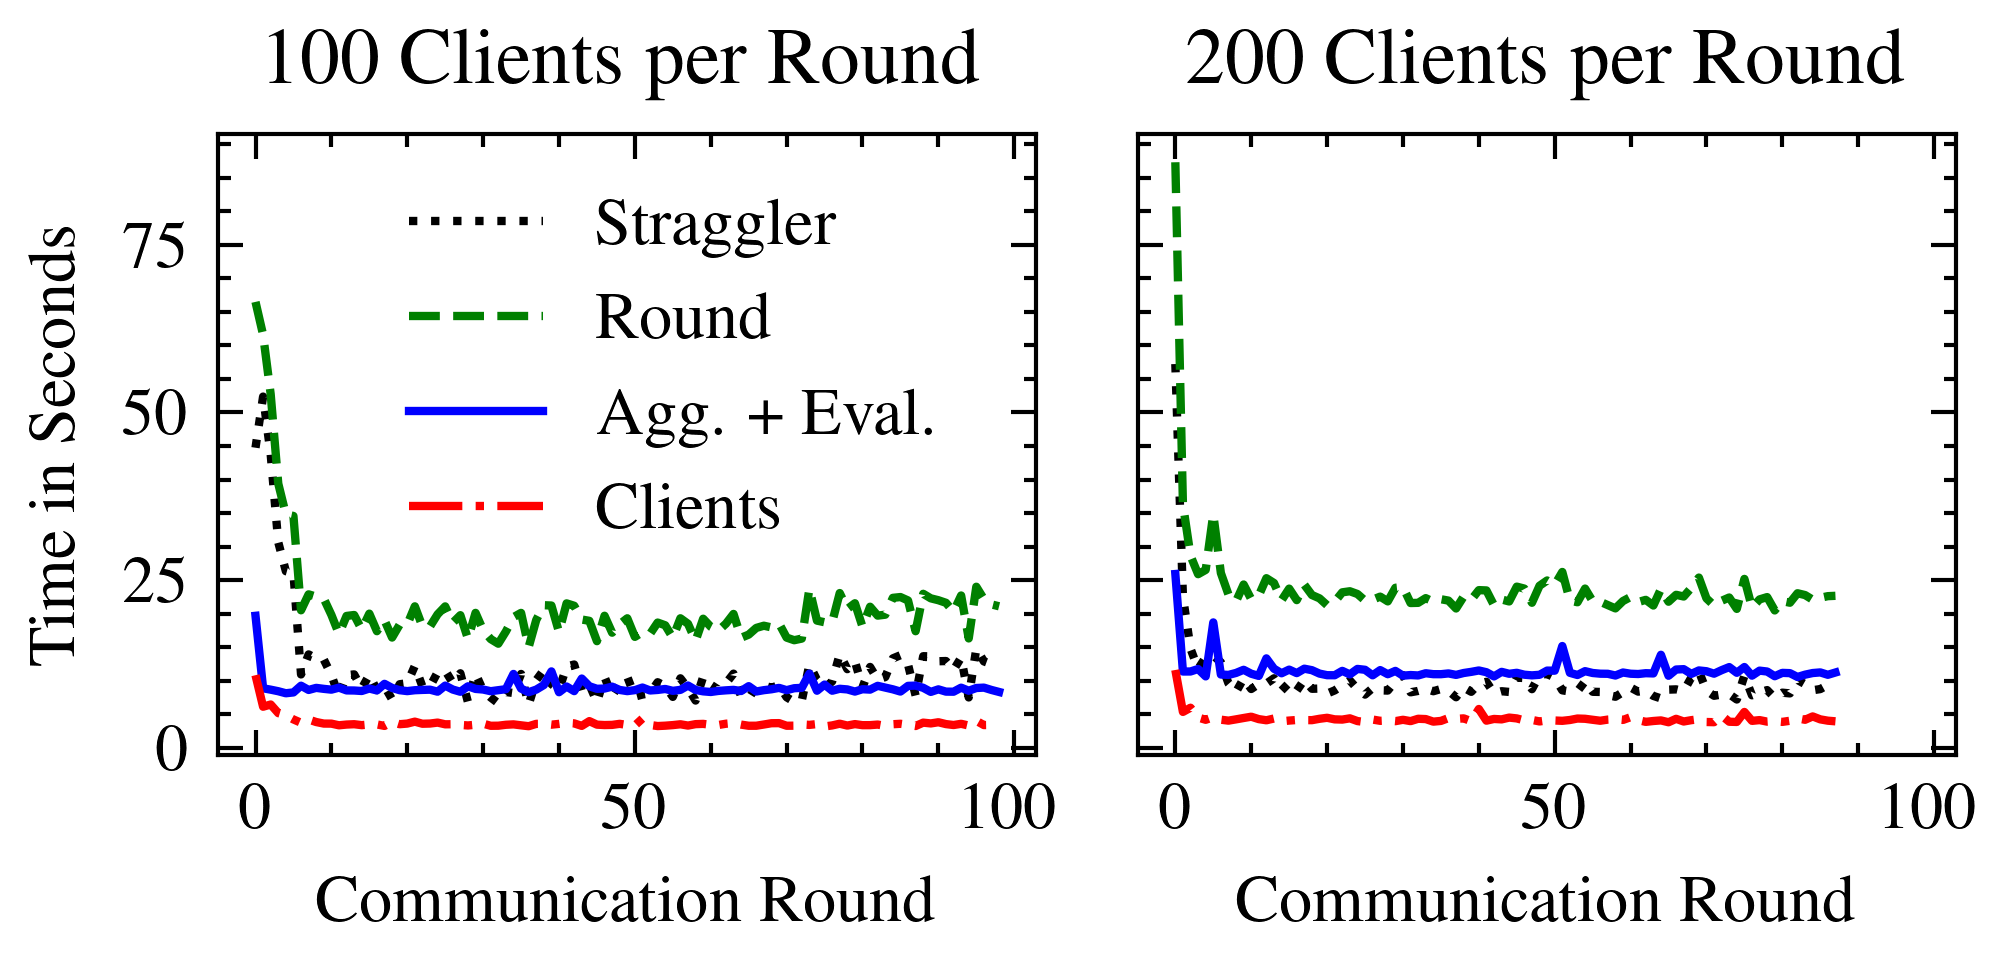

In [222]:
dataset = "mnist"
df_ = fedless_df.loc[(dataset, slice(1, 200), 200), :]
clients_df_ = fedless_clients_df.loc[(dataset, slice(1, 200), 200), :]#.reset_index()    
mean_maximum_client_per_round_df = clients_df_.groupby(["clients-round", "seed", "round"]).max("seconds").groupby(["clients-round", "round"]).mean()
mean_client_per_round_df = clients_df_.groupby(["clients-round", "round"]).mean()
mean_round_df = df_.groupby(["clients-round", "round"]).mean()

plt.clf()
fig, axarr = plt.subplots(ncols=2, sharey=True, sharex=True, figsize=(3.5, 3.5 / 2))
for i, clients in enumerate([100, 200]):
    sns.lineplot(
        x="round",
        y="seconds",
        data=mean_maximum_client_per_round_df.loc[clients],
        ax=axarr[i],
        label="Straggler"
    )
    sns.lineplot(
        x="round",
        y="time",
        data=df_.loc[("mnist", clients)],
        ax=axarr[i],
        label="Round",
        ci=None # 'sd'    
    )
    sns.lineplot(
        x="round",
        y="time-aggregation",
        data=mean_round_df.loc[clients],
        ax=axarr[i],
        label="Agg. + Eval."
    )
    sns.lineplot(
        x="round",
        y="seconds",
        data=clients_df_.loc[(dataset, clients)],
        ax=axarr[i],
        label="Clients",
        ci=None # 'sd'
    )
    axarr[i].set_title(f"{clients} Clients per Round")
    axarr[i].set_xlabel("Communication Round")
    axarr[i].set_ylabel("Time in Seconds")
    axarr[i].get_legend().remove()
    
handles, labels = axarr[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.19, 0.41))
fig.tight_layout()
fig.savefig(PLOT_OUTPUT_DIR / f"fedless-{dataset}-times.pdf", bbox_inches ='tight',pad_inches=0)

<Figure size 1980x1500 with 0 Axes>

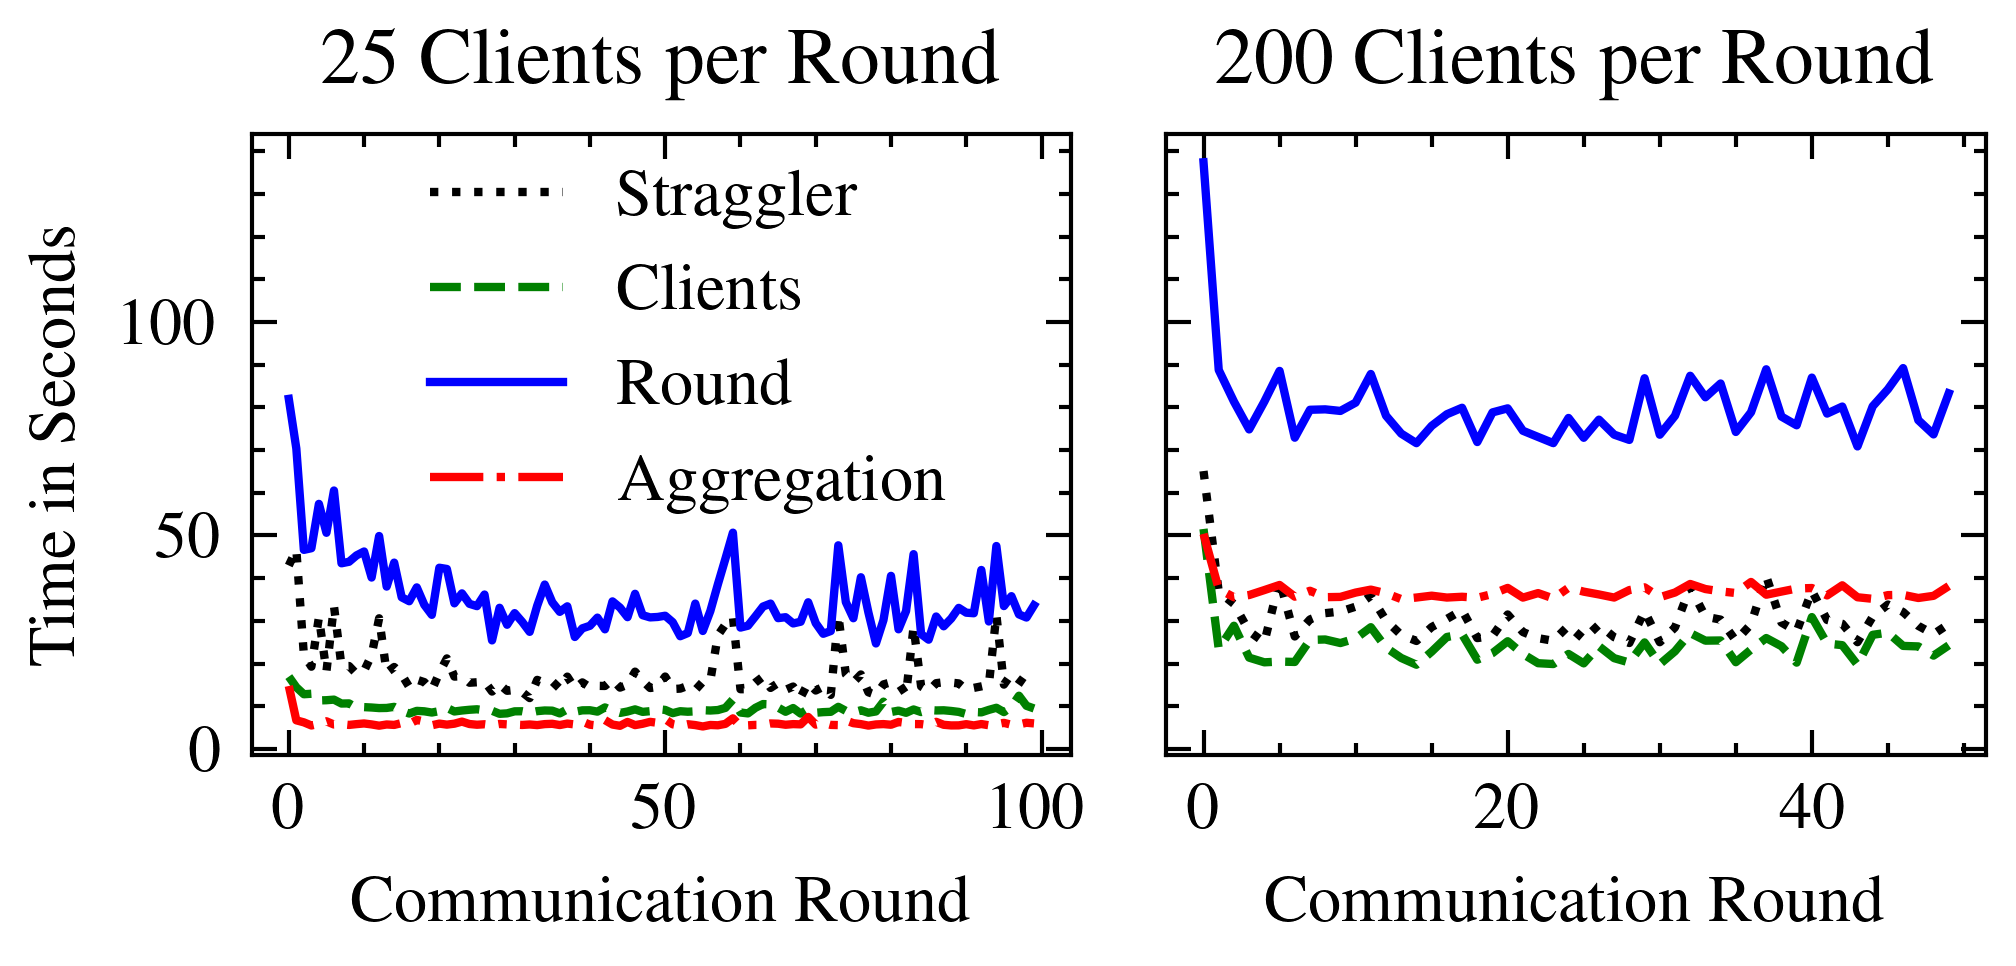

In [141]:
dataset = "femnist"
df_ = fedless_df.loc[(dataset, slice(1, 200), 200), :]
mean_round_df = df_.groupby(["clients-round", "round"]).mean()

clients_df_ = fedless_clients_df.loc[(dataset, slice(1, 200), 200), :]
clients_train_df_ = clients_df_[clients_df_["eval"] == False]
mean_maximum_client_per_round_df = clients_df_.groupby(["eval", "clients-round", "seed", "round"]).max("seconds").groupby(["eval", "clients-round", "round"]).mean()
mean_client_per_round_df = clients_df_.groupby(["eval", "clients-round", "round"]).mean()

plt.clf()
fig, axarr = plt.subplots(ncols=2, sharey=True, sharex=False, figsize=(3.5, 3.5 / 2))
for i, clients in enumerate([25, 200]):
    sns.lineplot(
        x="round",
        y="seconds",
        data=mean_maximum_client_per_round_df.loc[(False, clients), :],
        ax=axarr[i],
        label="Straggler"
    )
    sns.lineplot(
        x="round",
        y="seconds",
        data=clients_train_df_.loc[(dataset, clients), :], # mean_client_per_round_df.loc[(False, clients), :],
        ax=axarr[i],
        label="Clients",
        ci=None
    )
    sns.lineplot(
        x="round",
        y="time",
        data=mean_round_df.loc[clients],
        ax=axarr[i],
        label="Round"
    )
    sns.lineplot(
        x="round",
        y="time-aggregation",
        data=mean_round_df.loc[clients],
        ax=axarr[i],
        label="Aggregation"
    )
    #sns.lineplot(
    #    x="round",
    #    y="seconds",
    #    data=mean_client_per_round_df.loc[(True, clients), :],
    #    ax=axarr[i],
    #    label="Evaluation"
    #)
    axarr[i].set_title(f"{clients} Clients per Round")
    axarr[i].set_xlabel("Communication Round")
    axarr[i].set_ylabel("Time in Seconds")
    axarr[i].get_legend().remove()
    
handles, labels = axarr[-1].get_legend_handles_labels()
#fig.legend(handles, labels,loc="center left", bbox_to_anchor=(1, 0.5)) #  loc=(0.845, 0.29), 
fig.legend(handles, labels,loc=(0.2, 0.44)) 
fig.tight_layout()
fig.savefig(PLOT_OUTPUT_DIR / f"fedless-{dataset}-times.pdf", bbox_inches ='tight',pad_inches=0)

In [8]:
mean_round_df.groupby("clients-round").mean()

,time-aggregation,time,time-clients,clients,accuracy,loss
clients-round,,,,,,
25,5.950768,35.622659,19.813554,25,0.733513,1.110087
100,19.151926,47.958312,21.901537,100,0.743311,1.055212
200,36.801349,80.138536,32.973866,200,0.697378,1.236603


<Figure size 1980x1500 with 0 Axes>

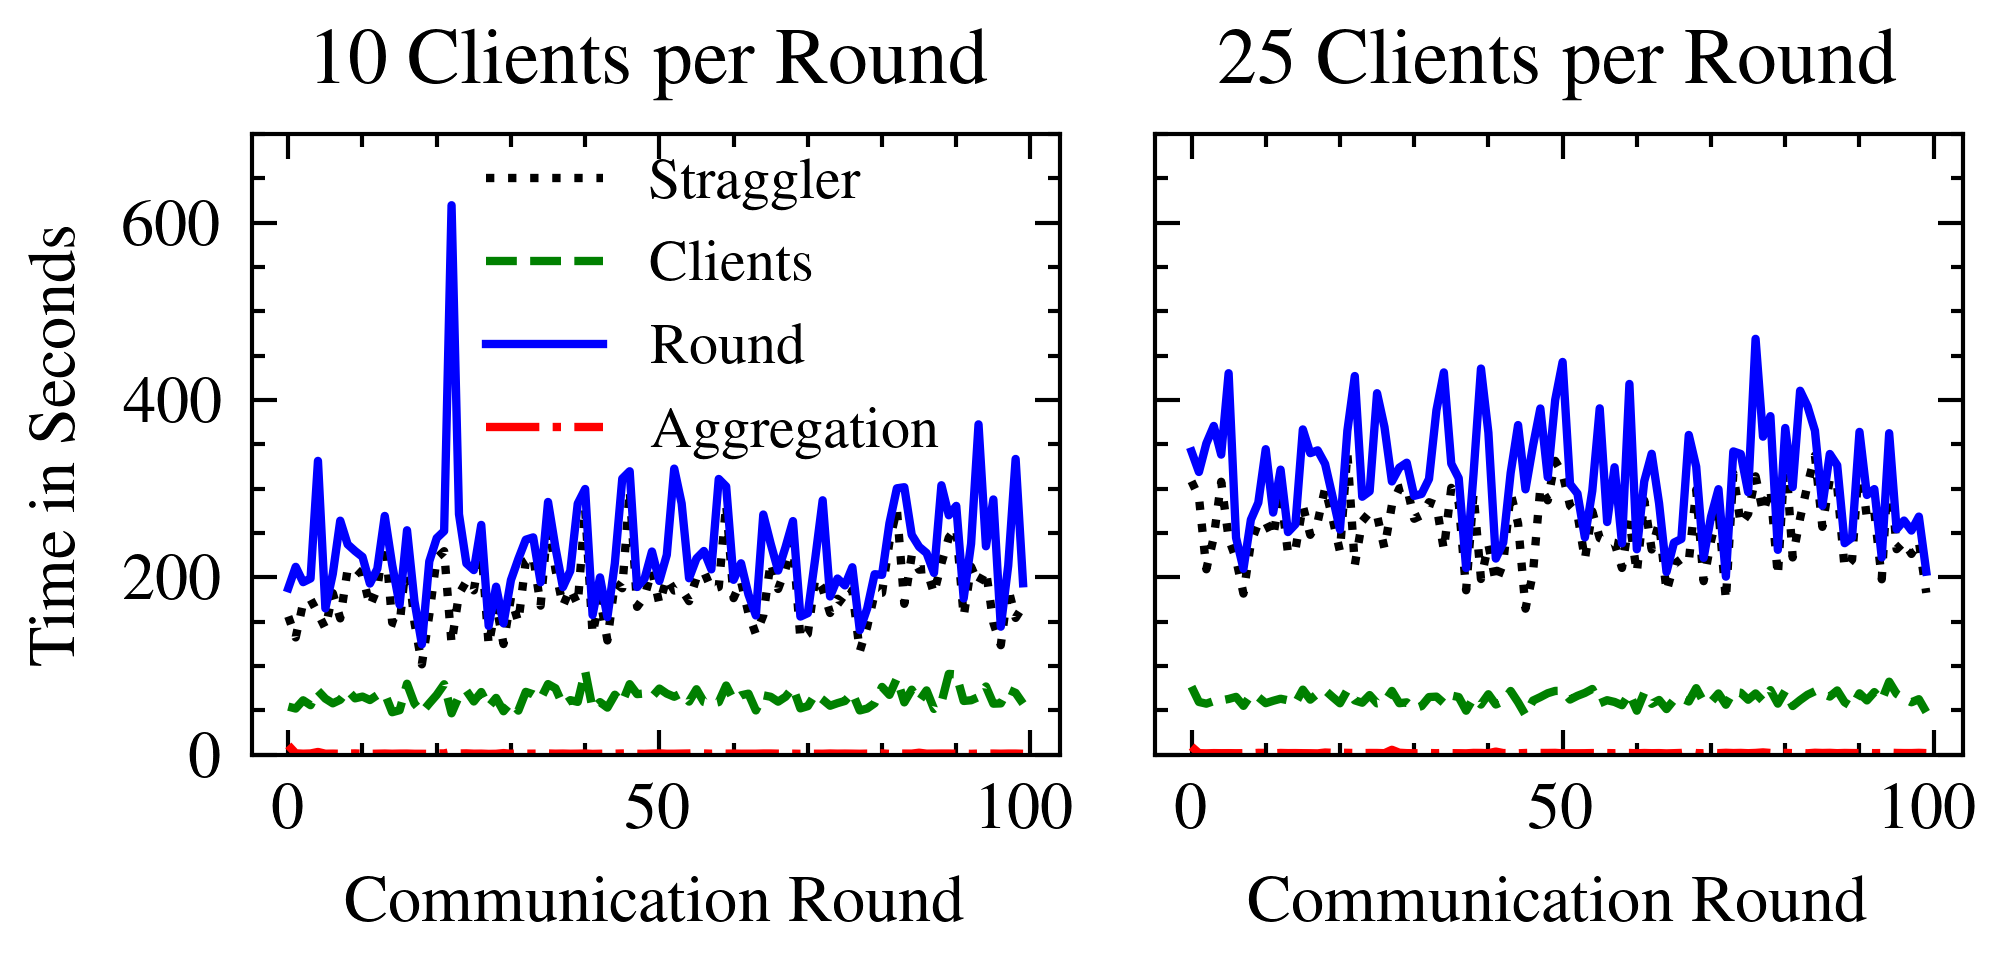

In [215]:
dataset = "shakespeare"
df_ = fedless_df.loc[(dataset, slice(1, 200), 200), :]

clients_df_ = fedless_clients_df.loc[(dataset, slice(1, 200), 200), :]#.reset_index()    
clients_train_df_ = clients_df_[clients_df_["eval"] == False]
clients_eval_df_ = clients_df_[clients_df_["eval"] == True]
mean_maximum_client_per_round_df = clients_df_.groupby(["eval", "clients-round", "seed", "round"]).max("seconds").groupby(["eval", "clients-round", "round"]).mean()
mean_client_per_round_df = clients_df_.groupby(["eval", "clients-round", "round"]).mean()
mean_round_df = df_.groupby(["clients-round", "round"]).mean()

plt.clf()
fig, axarr = plt.subplots(ncols=2, sharey=True, sharex=True, figsize=(3.5, 3.5 / 2))
for i, clients in enumerate([10, 25]):
    sns.lineplot(
        x="round",
        y="seconds",
        data=mean_maximum_client_per_round_df.loc[(False, clients), :],
        ax=axarr[i],
        label="Straggler"
    )
    sns.lineplot(
        x="round",
        y="seconds",
        data=clients_train_df_.loc[(dataset, clients), :], # mean_client_per_round_df.loc[(False, clients), :],
        ax=axarr[i],
        ci=None,
        label="Clients",
    )
    sns.lineplot(
        x="round",
        y="time",
        data=mean_round_df.loc[clients],
        ax=axarr[i],
        label="Round"
    )
    sns.lineplot(
        x="round",
        y="time-aggregation",
        data=mean_round_df.loc[clients],
        ax=axarr[i],
        label="Aggregation"
    )
    #ns.lineplot(
    #   x="round",
    #   y="seconds",
    #   data=mean_client_per_round_df.loc[(True, clients), :],
    #   ax=axarr[i],
    #   label="Evaluation"
    #
    axarr[i].set_title(f"{clients} Clients per Round")
    axarr[i].set_xlabel("Communication Round")
    axarr[i].set_ylabel("Time in Seconds")
    axarr[i].set_ylim((0, 700))
    axarr[i].get_legend().remove()
    
handles, labels = axarr[-1].get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc=(.23, .5), fontsize=7) #loc="center left", bbox_to_anchor=(0.95, 0.5))
fig.tight_layout()

fig.savefig(PLOT_OUTPUT_DIR / f"fedless-{dataset}-times.pdf", bbox_inches ='tight',pad_inches=0)

<Figure size 1980x1500 with 0 Axes>

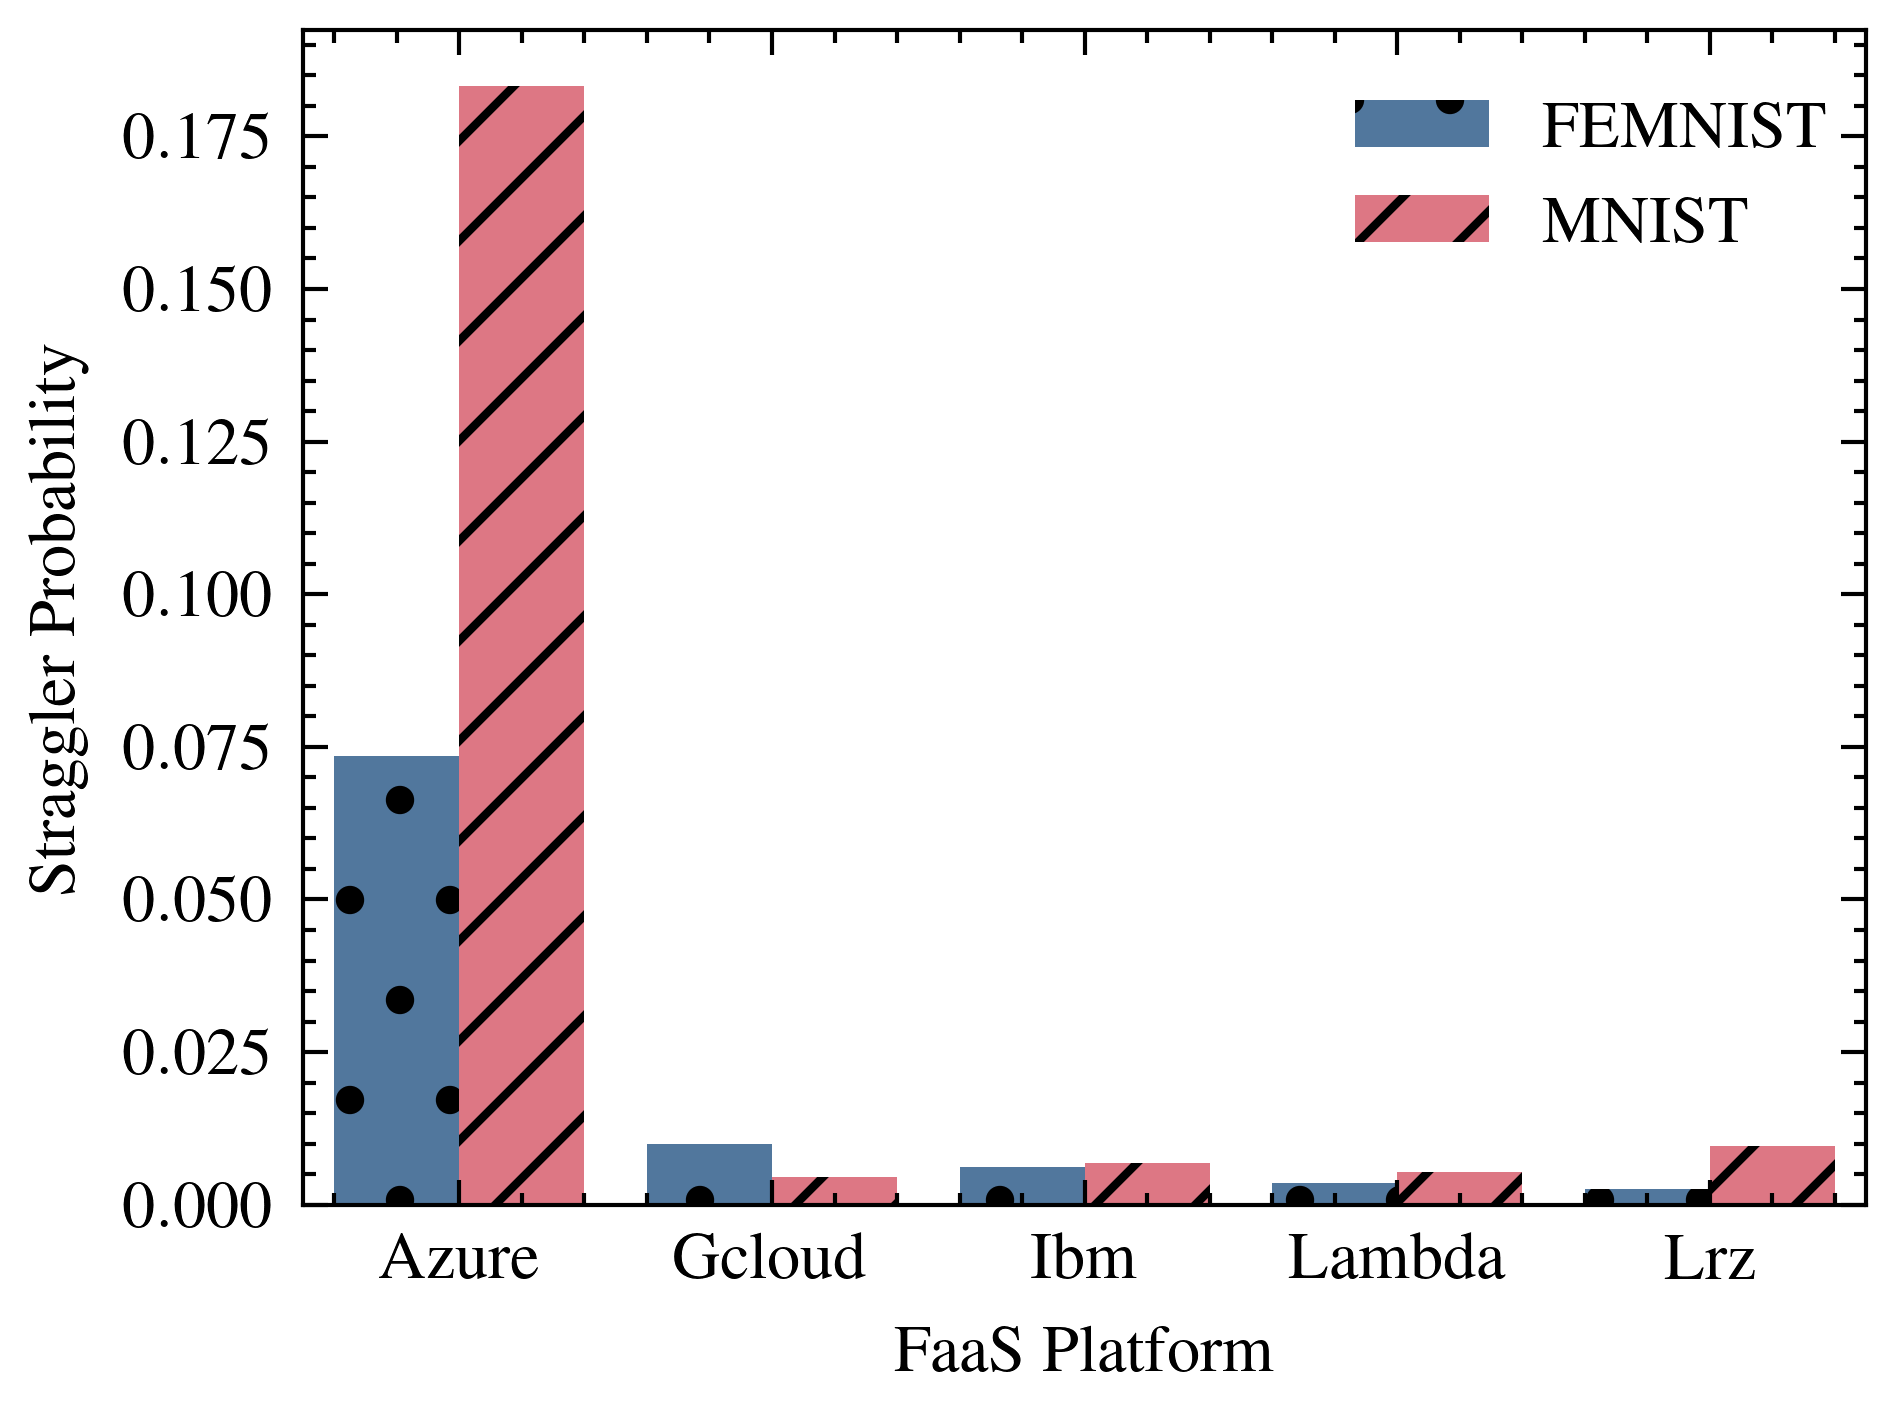

In [10]:
clients_df_ = fedless_clients_df.loc[(("mnist", "femnist"), slice(1, 200), 200), :].reset_index()
clients_df_ = clients_df_[clients_df_["eval"] == False]

df_ = (
    clients_df_.loc[clients_df_.groupby(["dataset", "seed", "round"]).idxmax()["seconds"], :].groupby(["dataset", "platform"]).size() / 
    clients_df_.groupby(["dataset", "platform"]).size()
).reset_index()
df_["dataset"] = df_["dataset"].str.upper()
df_["platform"] = df_["platform"].str.capitalize()
plt.clf()
with plt.style.context(['science', 'ieee', 'bright']):
    fig, ax = plt.subplots()
    sns.barplot(
        y=0,
        x="platform",
        hue="dataset",
        data=df_,
        ax=ax,
        #linewidth=1, 
        #facecolor=(1, 1, 1, 0),
        #errcolor=".2", 
        #edgecolor=".2"
    )

    num_locations = len(df_.platform.unique())
    hatches = itertools.cycle(['.', '//', '+', '-', 'x', '\\', '', 'o', 'O', '.'])
    for i, bar in enumerate(ax.patches):
        if i % num_locations == 0:
            hatch = next(hatches)
        bar.set_hatch(hatch)

    ax.set_xlabel("FaaS Platform")
    ax.set_ylabel("Straggler Probability")
    ax.get_legend().remove()
    fig.legend(loc=(0.7, 0.8))
    fig.tight_layout()
    fig.savefig(PLOT_OUTPUT_DIR / f"fedless-platforms-dropout-prob.pdf", bbox_inches ='tight',pad_inches=0)

<Figure size 1980x1500 with 0 Axes>

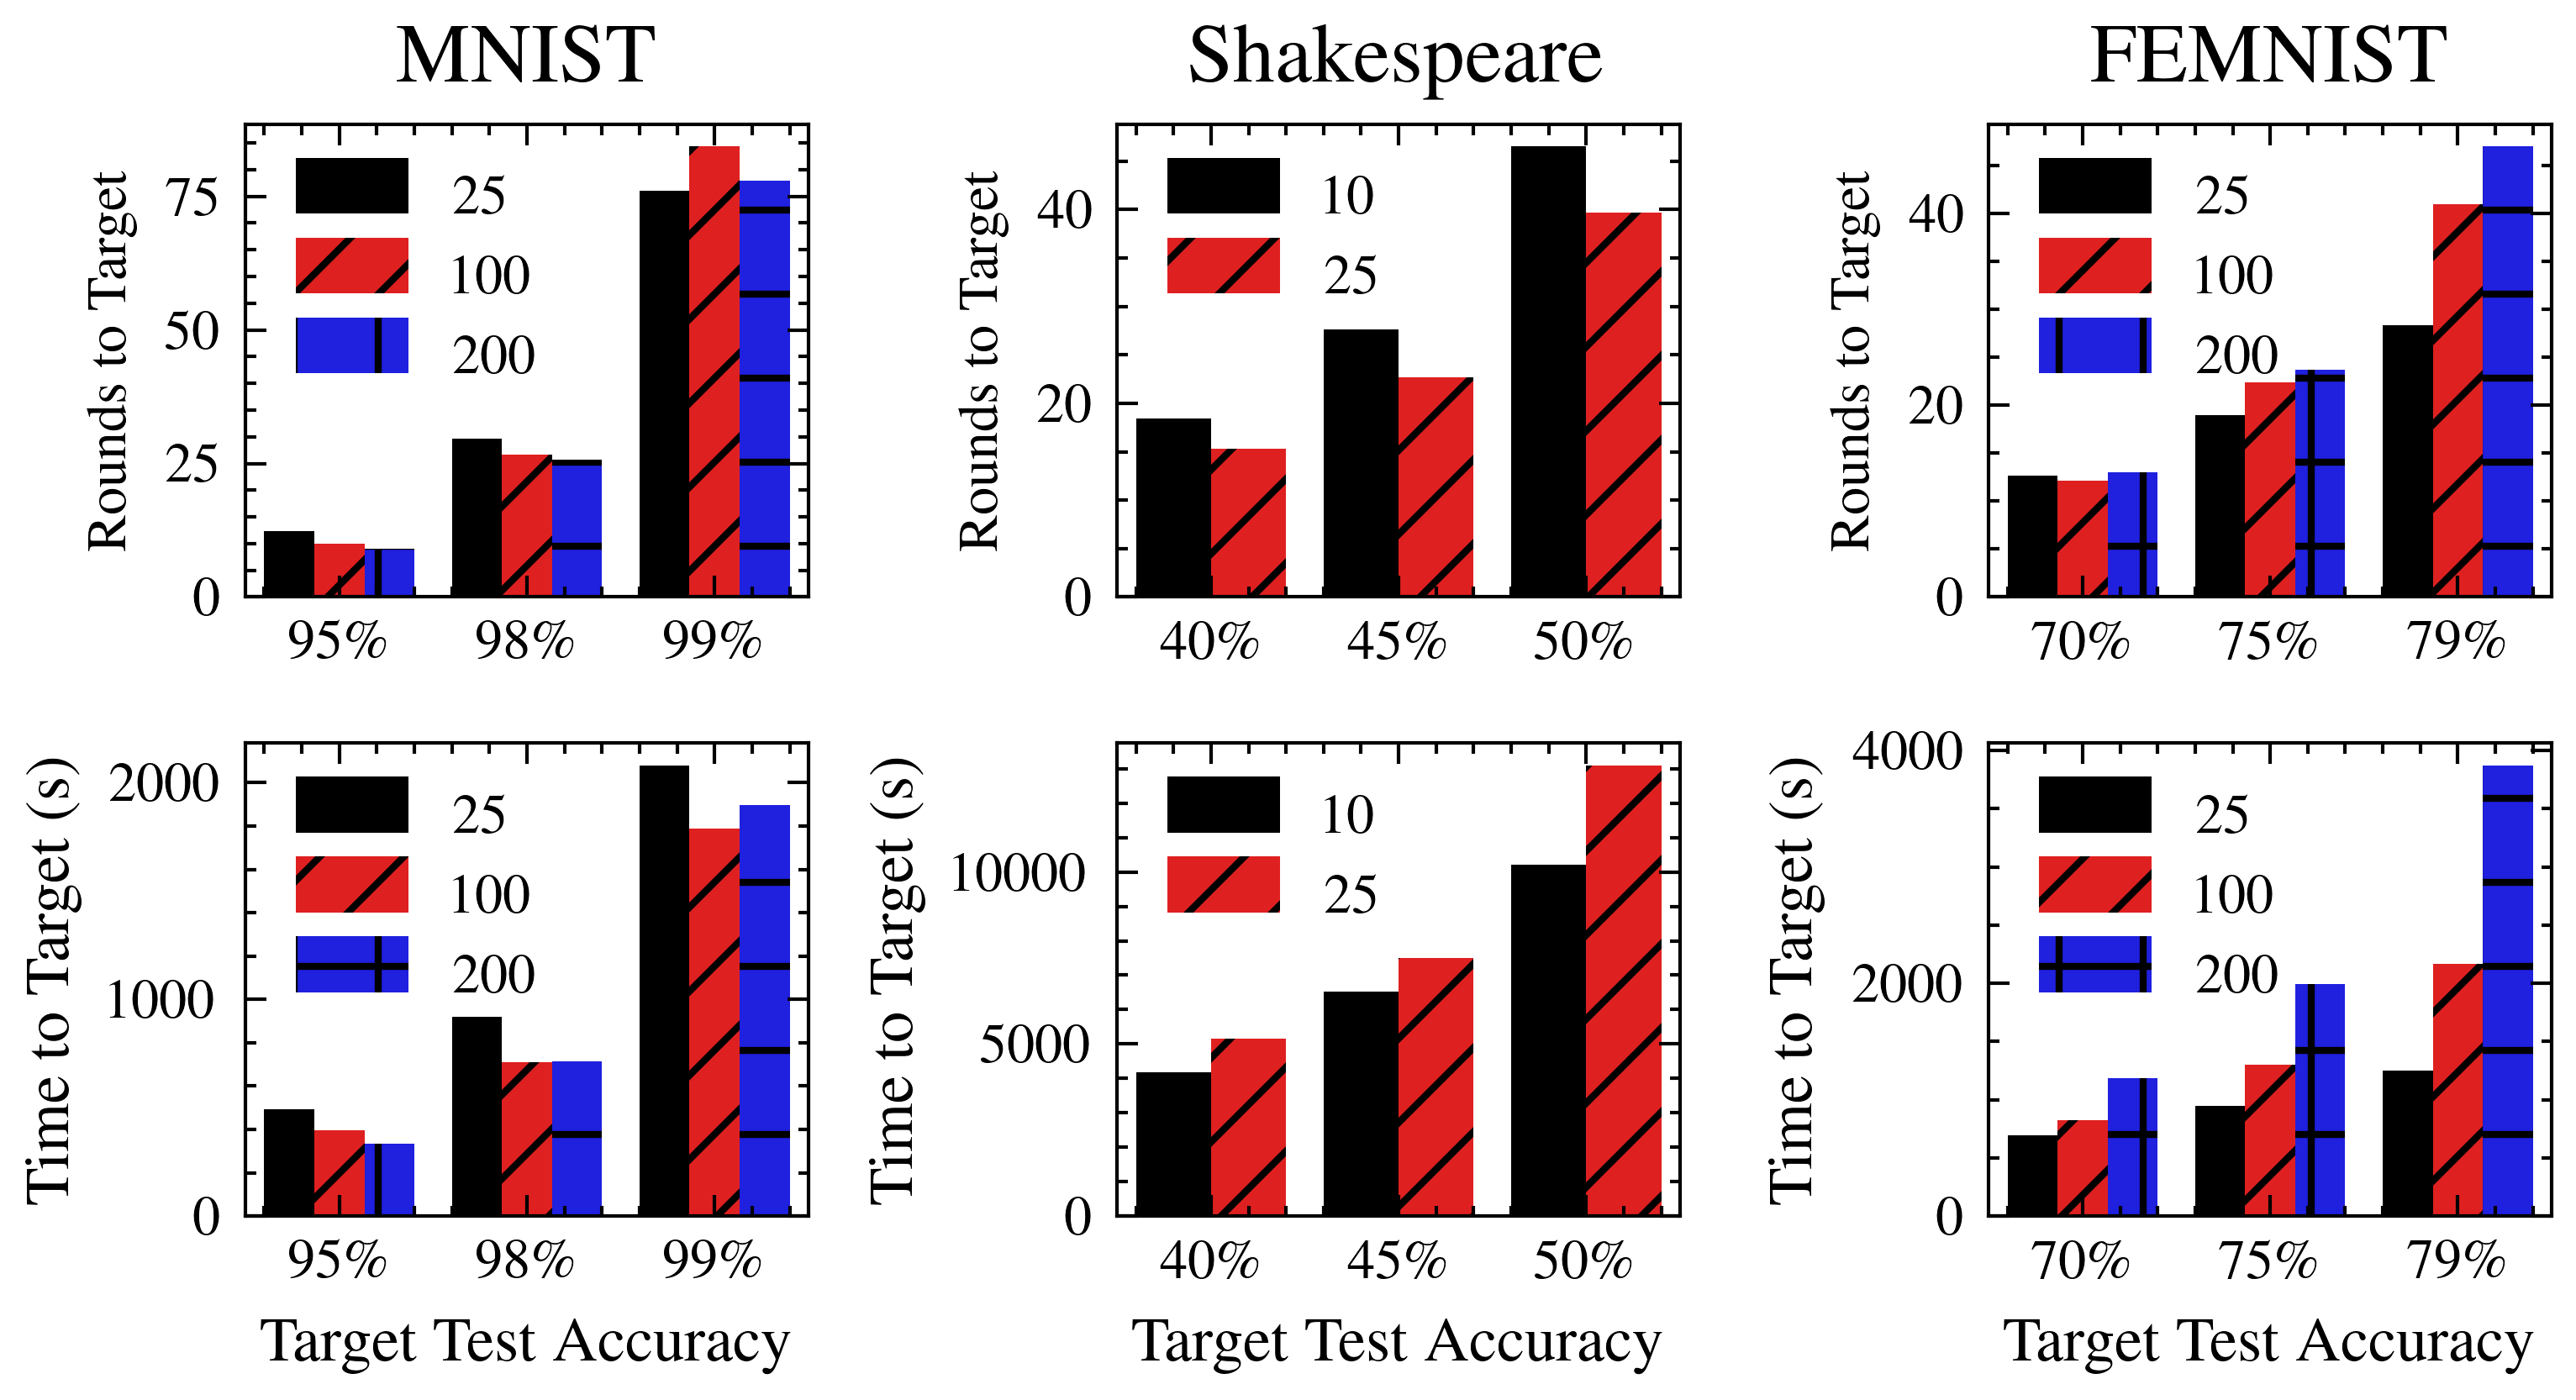

In [188]:
plt.clf()
fig, axarr = plt.subplots(nrows=2, ncols=3, sharex="col", figsize=(3.5 * 1.5, 3.5 / 1.2))

fedless_df_ = fedless_df.copy()
fedless_df_['time-total'] = fedless_df_.groupby(["dataset", "clients-round", "seed"])['time'].transform(pd.Series.cumsum)

with plt.style.context(['science', 'bright', 'ieee', {"font.size": 8, "axes.titlesize": 12}]):

    for i, (dataset, target_accuracies) in enumerate([
        ("mnist", [0.95, 0.98, 0.99]),
        ("shakespeare", [0.4, 0.45, 0.5]),
        ("femnist", [0.7, 0.75, 0.79])
        ]): #, "femnist", "shakespeare"]):
        dataset_df_ = fedless_df_.loc[(dataset, slice(1, 200), 200), :]
        dfs_ = []
        for acc in target_accuracies:
            df_ = dataset_df_.copy()
            df_ = df_[df_["accuracy"] >= acc]
            df_ = df_.groupby(["clients-round", "seed"]).min("round")
            dfs_.append(df_)
        df_ = pd.concat(dfs_, keys=[f"{int(t * 100)}\%" for t in target_accuracies], names=["target"]).reset_index()
        sns.barplot(
            x="target",
            y="round",
            hue="clients-round",
            data=df_,
            ax=axarr[0, i],
            ci=None
        )
        axarr[0, i].get_legend().set_title("Clients")
        axarr[0, i].set_xlabel("")
        axarr[0, i].set_ylabel("Rounds to Target") #if i == 0 else "")
        axarr[0, i].set_title(dataset.capitalize() if not "mnist" in dataset else dataset.upper())
        axarr[0, i].xaxis.set_tick_params(which='both', labelbottom=True)



        num_locations = len(target_accuracies)
        hatches = itertools.cycle(['.', '//', '+', '-', 'x', '\\', '', 'o', 'O', '.'])
        for j, bar in enumerate(axarr[0, i].patches):
            if j % num_locations == 0:
                hatch = next(hatches)
            bar.set_hatch(hatch)

        sns.barplot(
            x="target",
            y="time-total",
            hue="clients-round",
            data=df_,
            ax=axarr[1, i],
            ci=None
        )
        axarr[1, i].get_legend().set_title("Clients")
        axarr[1, i].set_xlabel("Target Test Accuracy", fontsize=9)
        axarr[1, i].set_ylabel("Time to Target (s)", fontsize=9) # if i == 0 else "")          
            
        axarr[1, i].set_title("")
        
        hatches = itertools.cycle(['.', '//', '+', '-', 'x', '\\', '', 'o', 'O', '.'])
        for j, bar in enumerate(axarr[1, i].patches):
            if j % num_locations == 0:
                hatch = next(hatches)
            bar.set_hatch(hatch)
        
        axarr[0, i].get_legend().remove()
        axarr[1, i].get_legend().remove()
        for leg in [axarr[0, i].legend(), axarr[1, i].legend()]:
            for patch in leg.get_patches():
                patch.set_height(8)
            
fig.tight_layout()
fig.savefig(PLOT_OUTPUT_DIR / f"fedless-convergence-rounds-and-time.pdf", bbox_inches ='tight', pad_inches=0)

<Figure size 1980x1500 with 0 Axes>

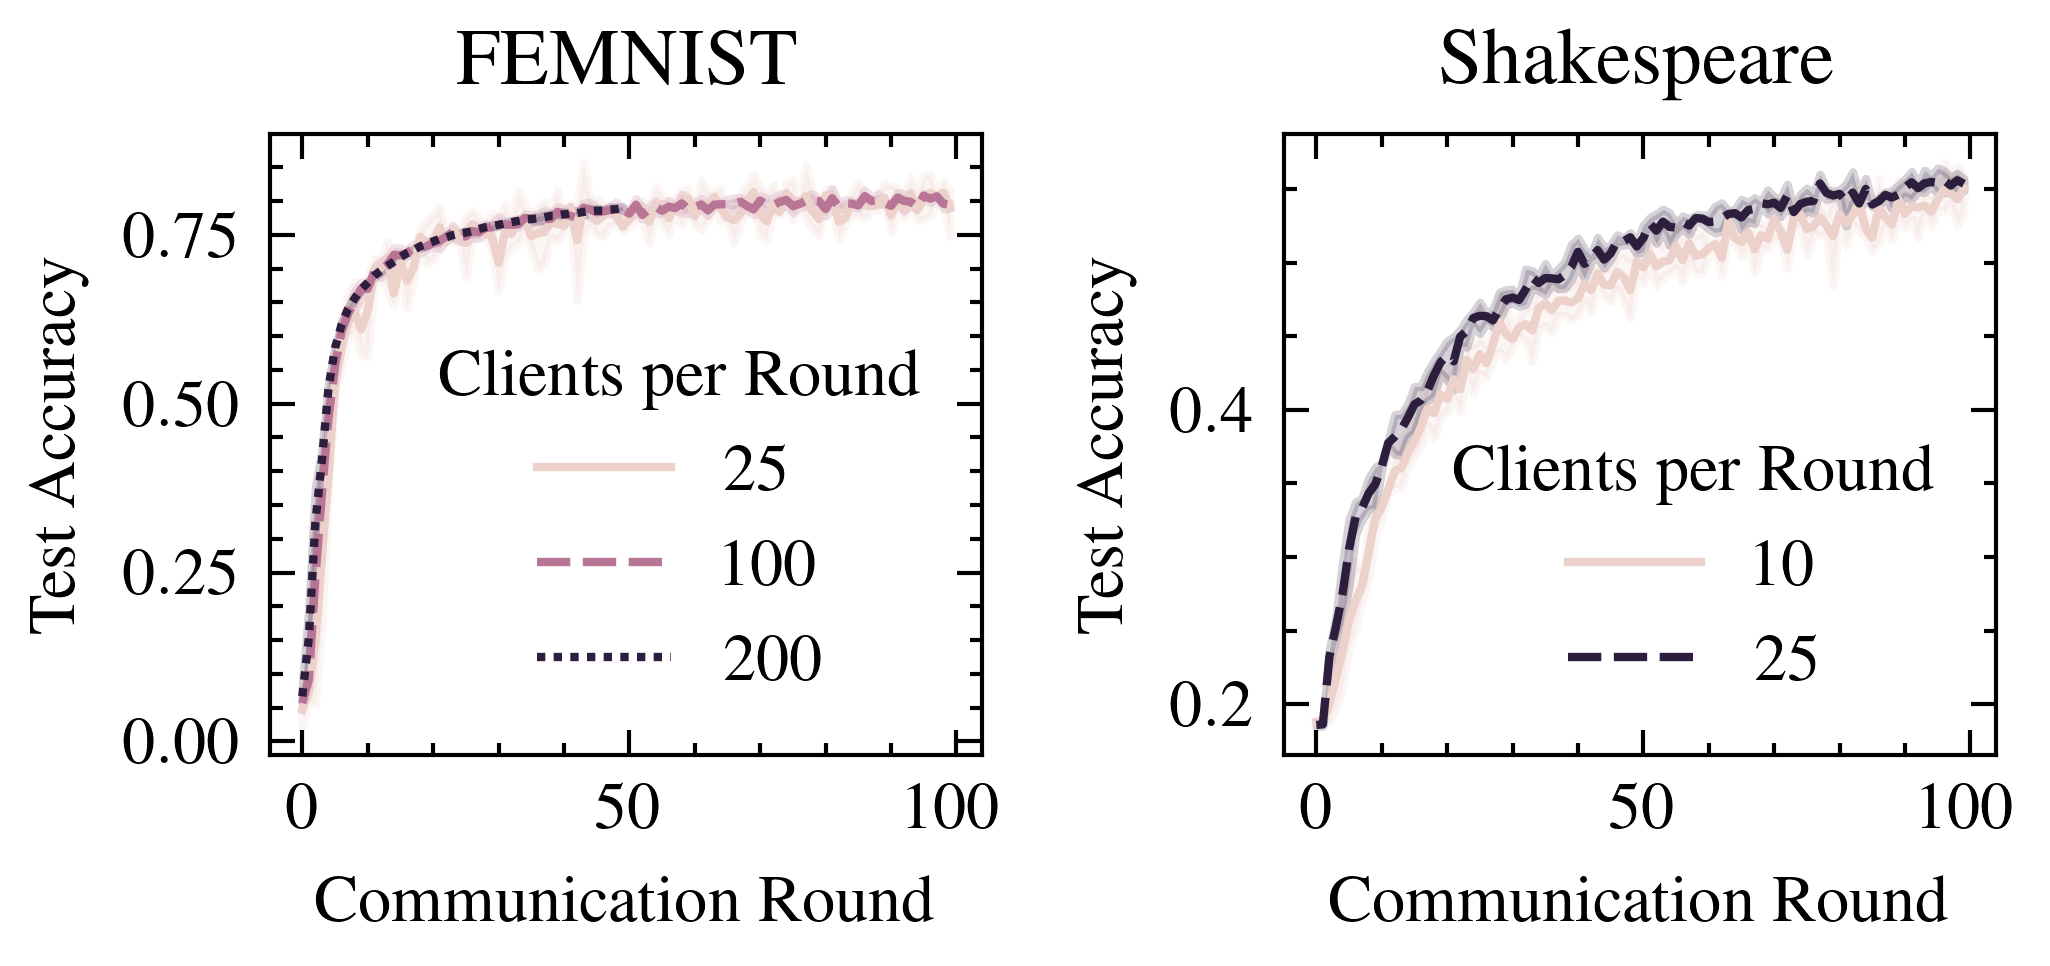

In [122]:
plt.clf()
fig, axarr = plt.subplots(ncols=2, sharex="col", figsize=(3.5, 3.5 / 2))
with plt.style.context(['science', 'bright', 'ieee']):
    sns.lineplot(
        x="round",
        y="accuracy",
        hue="clients-round",
        style="clients-round",
        data=fedless_df_.loc[("femnist", slice(1, 200), 200), :],
        ax=axarr[0],
    )
    sns.lineplot(
        x="round",
        y="accuracy",
        hue="clients-round",
        style="clients-round",
        data=fedless_df_.loc[("shakespeare", slice(1, 200), 200), :],
        ax=axarr[1],
    )
    axarr[0].set_xlabel("Communication Round")
    axarr[0].set_ylabel("Test Accuracy")
    axarr[0].set_title("FEMNIST")
    axarr[1].set_xlabel("Communication Round")
    axarr[1].set_ylabel("Test Accuracy")
    axarr[1].set_title("Shakespeare")
    axarr[0].get_legend().set_title("Clients per Round")
    axarr[1].get_legend().set_title("Clients per Round")
    fig.tight_layout()
    fig.savefig(PLOT_OUTPUT_DIR / f"fedless-convergence-curves.pdf", bbox_inches ='tight', pad_inches=0)

<Figure size 1980x1500 with 0 Axes>

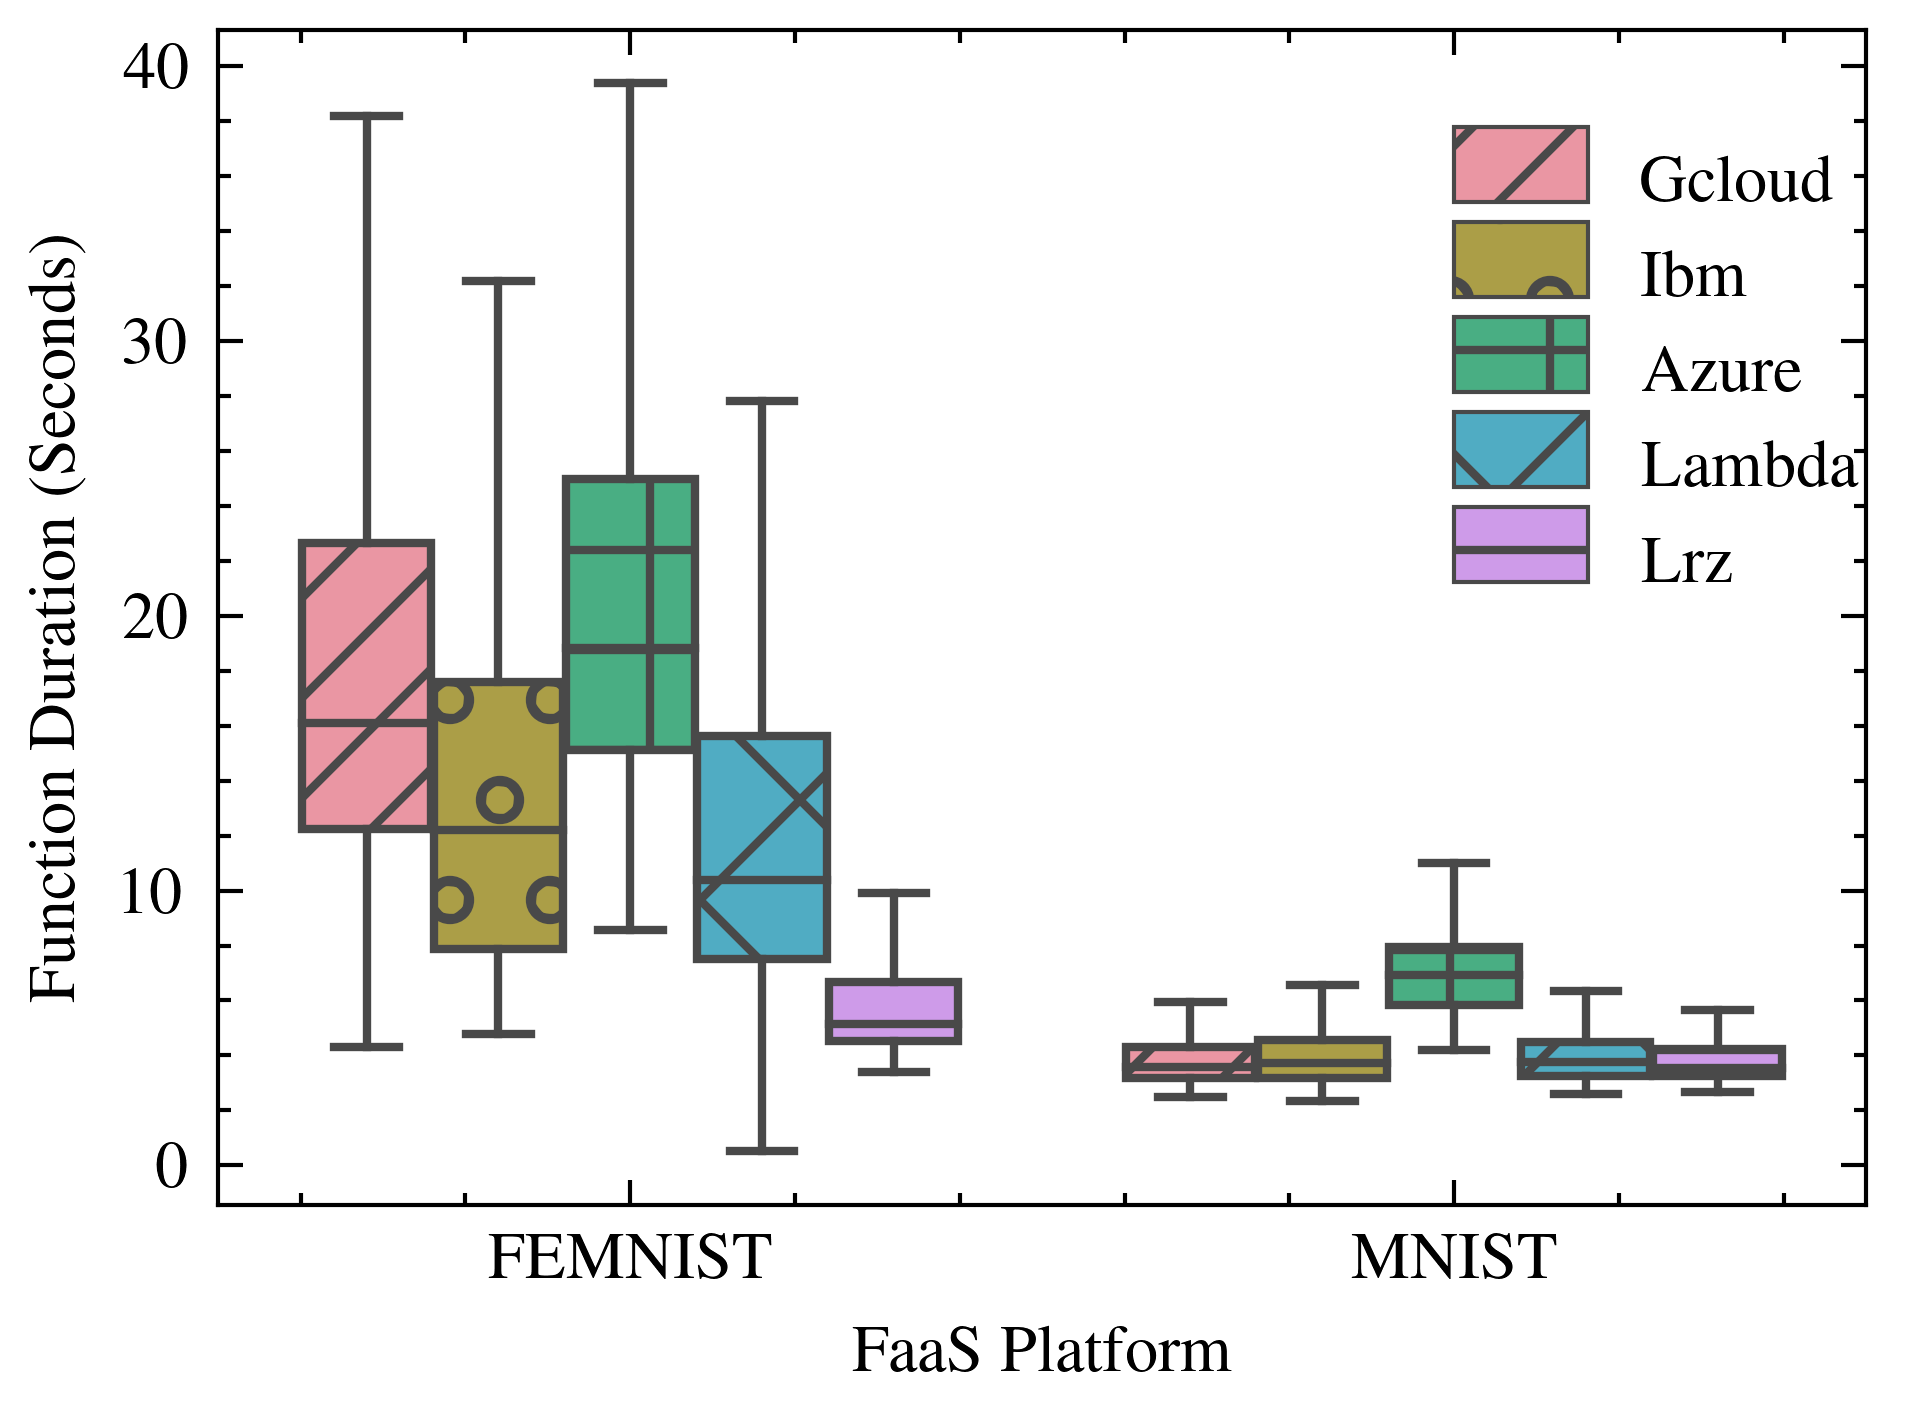

In [13]:
plt.clf()
fig, ax = plt.subplots() # nrows=2, ncols=3, sharex="col", figsize=(7.167, 7.167 / 2))

df_ = fedless_clients_df.reset_index()
df_ = df_[df_["clients-total"] == 200]
df_ = df_[df_["eval"] == False]
df_ = df_[df_["dataset"] != "shakespeare"]
df_["dataset"] = df_["dataset"].apply(str.upper)
df_["platform"] = df_["platform"].apply(str.capitalize)

with plt.style.context(['science', 'ieee', 'bright']):
    sns.boxplot(
        x="dataset",
        y="seconds",
        hue="platform",
        data=df_,
        showfliers=False, # Mention in text that removed
        ax=ax
    )

hatches = itertools.cycle(['//', 'o', '+', 'x', '-', '.', 'x', '\\', '', '', 'O', '.'][:5]) # ['.', '//', '+', '-', 'x', '\\', '', 'o', 'O', '.'])
for i, patch in enumerate(ax.artists + ax.patches):
    hatch = next(hatches)
    patch.set_hatch(hatch)
#    patch.set_height(22)

ax.get_legend().remove()
leg = fig.legend(loc=(0.744, 0.56))
for patch in leg.get_patches():
    patch.set_height(9)

    
ax.set_xlabel("FaaS Platform")
ax.set_ylabel("Function Duration in Seconds")
fig.tight_layout()
fig.savefig(PLOT_OUTPUT_DIR / f"fedless-platforms-durations.pdf", bbox_inches ='tight', pad_inches=0)

In [151]:
log_df = pd.read_csv(ROOT_OUT_DIR / "fedkeeper-fedless-gcloud-logs/downloaded-logs-20210811-151304-client-indep-secure-1-july-august.csv")
log_df = log_df[["labels.execution_id", "timestamp", "textPayload"]]
log_df["timestamp"] = pd.to_datetime(log_df["timestamp"])
log_df.rename(columns={"labels.execution_id": "execution_id"}, inplace=True)
log_df.set_index(["execution_id", "timestamp"], inplace=True)
log_df.sort_index(inplace=True)

log_events = [
        ("load-model", ("Loading model from database", "Model successfully loaded")),
        ("training", ("Running training", "Serializing model parameters")),
        ("model-serialization", ("Serializing model parameters", "Finished serializing mode")),
        ("store-model", ("Storing client results", "Finished writing to")),
        ("compile-model", ("Compiling model", "Running training")),
        ("load-data", ("Loading dataset...", "Finished loading dataset....")),
        #("token-verification-warm", ("Function execution started", "handler called for session...")),
        #("token-verification-cold", ("Did not find public keys, fetchin", "handler called for session...")),
        #("cache-hit", "INFO:fedless.cache:Cache Hit"),
        #("cache-miss", "INFO:fedless.cache:Cache Miss")
]

records = []
for name, group_df in log_df.groupby(["execution_id"]):
    try:
       
        tmp_ = {}
        for (event, (event_messages)) in log_events:
            if isinstance(event_messages, str):
                event_message = event_messages
                is_registered = not (group_df[group_df["textPayload"].str.contains(event_message)].empty)
                
                tmp_.update({
                    event: is_registered
                })
                
            else:
                try:
                    event_start, event_finish = event_messages
                    start_ts = group_df[group_df["textPayload"].str.contains(event_start)].index[0][1]
                    end_ts = group_df[group_df["textPayload"].str.contains(event_finish)].index[0][1]
                    seconds = (end_ts - start_ts).total_seconds()
                except IndexError as e:
                    if "token-verification" in event:
                        seconds = 0.0
                    else:
                        raise e
                    
                    
                tmp_.update({
                    event: seconds
                })
                
                
        model_size = group_df[group_df["textPayload"].str.contains("Serialized parameters:")].iloc[0].apply(lambda x: int(x.split(" ")[-2])).values[0]
        #client_id = group_df[group_df["textPayload"].str.contains("client_id=")].iloc[0].apply(lambda x: str(x.split("=")[-1])).values[0]
        model = { 2330095: "mnist", 26416831: "femnist", 3275841: "shakespeare"}.get(model_size)
            
        records.append({
            "execution_id": name,
            "model-size": model_size,
            "model": model,
            #"client-id": client_id,
            **tmp_
        })
    except IndexError as e:
        pass
    
fl_timing_details_df = pd.DataFrame.from_records(records)

<Figure size 1980x1500 with 0 Axes>

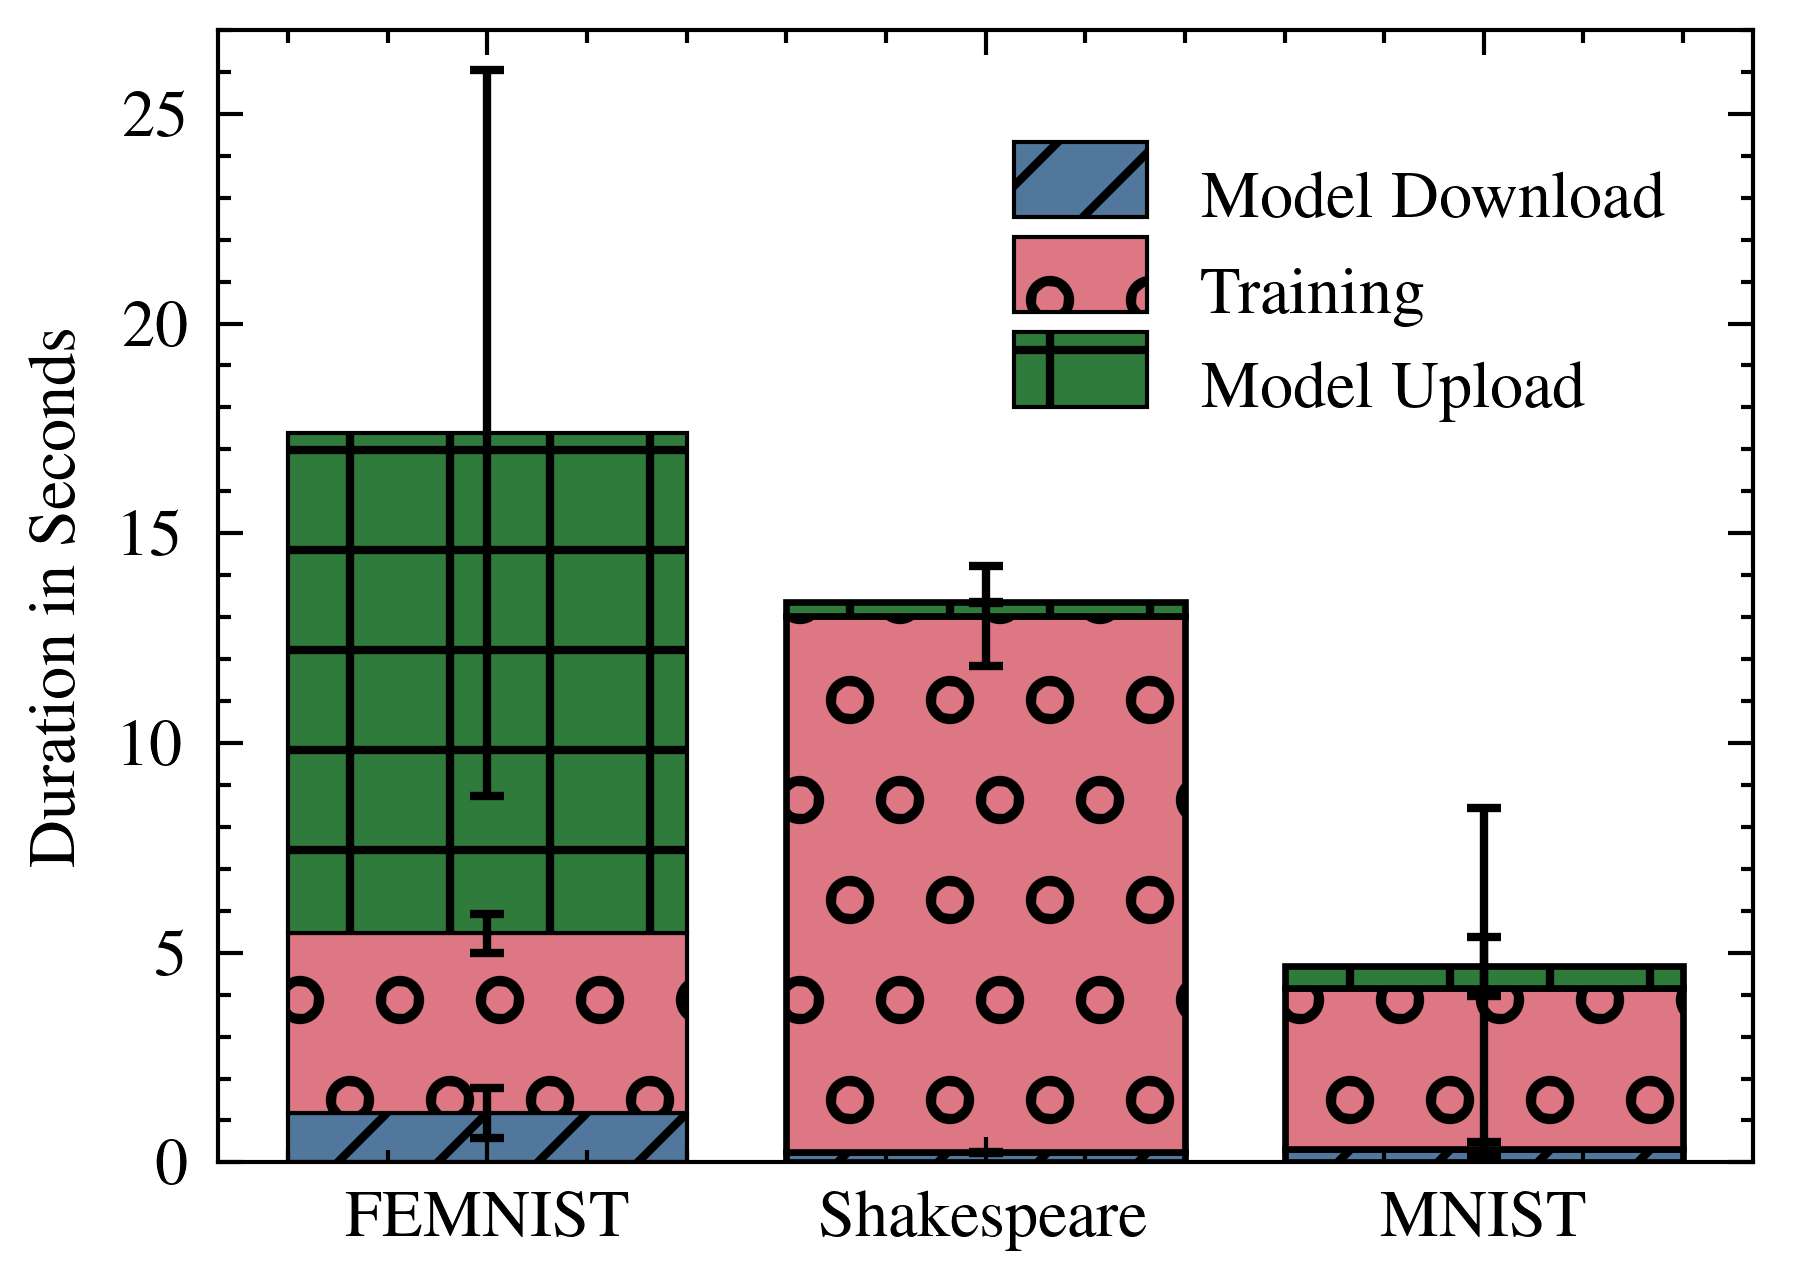

In [156]:
df_ = fl_timing_details_df

grouped_df = df_.groupby(["model"]) # "model", 
grouped_mean = grouped_df.mean()
grouped_std = grouped_df.std()
grouped_mean_femnist = grouped_mean.loc["femnist"]
grouped_std_femnist = grouped_std.loc["femnist"]
grouped_mean_shakespeare = grouped_mean.loc["shakespeare"]
grouped_std_shakespeare = grouped_std.loc["shakespeare"]
grouped_mean_mnist = grouped_mean.loc["mnist"]
grouped_std_mnist = grouped_std.loc["mnist"]


plt.clf()
fig, ax = plt.subplots() #, figsize=(12, 10))# plot bars # figsize=(7.167 /, 7.167 / 4)

bottom_fm, bottom_sh, bottom_mn = None, None, None
events = ["load-model", "training", "store-model"]
event_names = ["Model Download", "Training", "Model Upload"]
colors = ['#51779d', '#dd7784', '#2f7b3c', '#77c4dd', '#66CCEE', '#AA3377', '#BBBBBB'] #["tab:blue", "tab:green", "tab:red", "tab:purple", "tab:orange"]
hatches = itertools.cycle(['//', 'o', '+', 'x', '-', '.', 'x', '\\', '', '', 'O', '.'])
for event, event_name, color in zip(events, event_names, colors):
    hatch = next(hatches)
    vals_fm = grouped_mean_femnist[event]
    ax.bar(
        x=0,
        height=vals_fm,
        yerr=grouped_std_femnist[event],
        label=event_name,
        bottom=bottom_fm,
        color=color,
        hatch=hatch,
#        fill=False,
        alpha=1.0,
        capsize=2.0,
        linewidth=0.5,
        edgecolor='black',
        ecolor='black',
    )
    bottom_fm = bottom_fm or 0
    bottom_fm += vals_fm
    
    vals_sh = grouped_mean_shakespeare[event]
    ax.bar(
        x=1,
        height=vals_sh,
        yerr=grouped_std_shakespeare[event],
        bottom=bottom_sh,
        color=color,
        hatch=hatch,
#        fill=False,
        alpha=1.0,
        capsize=2.0,
        linewidth=0.8,
        edgecolor='black',
        ecolor='black',
    )
    bottom_sh = bottom_sh or 0
    bottom_sh += vals_sh
    
    vals_mn = grouped_mean_mnist[event]
    ax.bar(
        x=2,
        height=vals_mn,
        yerr=grouped_std_mnist[event],
        bottom=bottom_mn,
        color=color,
        hatch=hatch,
#        fill=False,
        alpha=1.0,
        capsize=2.0,
        linewidth=0.8,
        edgecolor='black',
        ecolor='black',
    )
    bottom_mn = bottom_mn or 0
    bottom_mn += vals_mn

ax.set_xticks([0, 1, 2])
ax.set_xticklabels(["FEMNIST", "Shakespeare", "MNIST"])
#ax.set_xscale('linear')
ax.set_ylabel('Duration in Seconds')
leg = fig.legend(loc=(0.55, 0.65))
for patch in leg.get_patches():
    patch.set_height(9)
ax.set_ylim(0.0, 27.0)
fig.savefig(PLOT_OUTPUT_DIR / f"fedless-gcloud-timings.pdf" ,bbox_inches = 'tight',pad_inches = 0)

<Figure size 1980x1500 with 0 Axes>

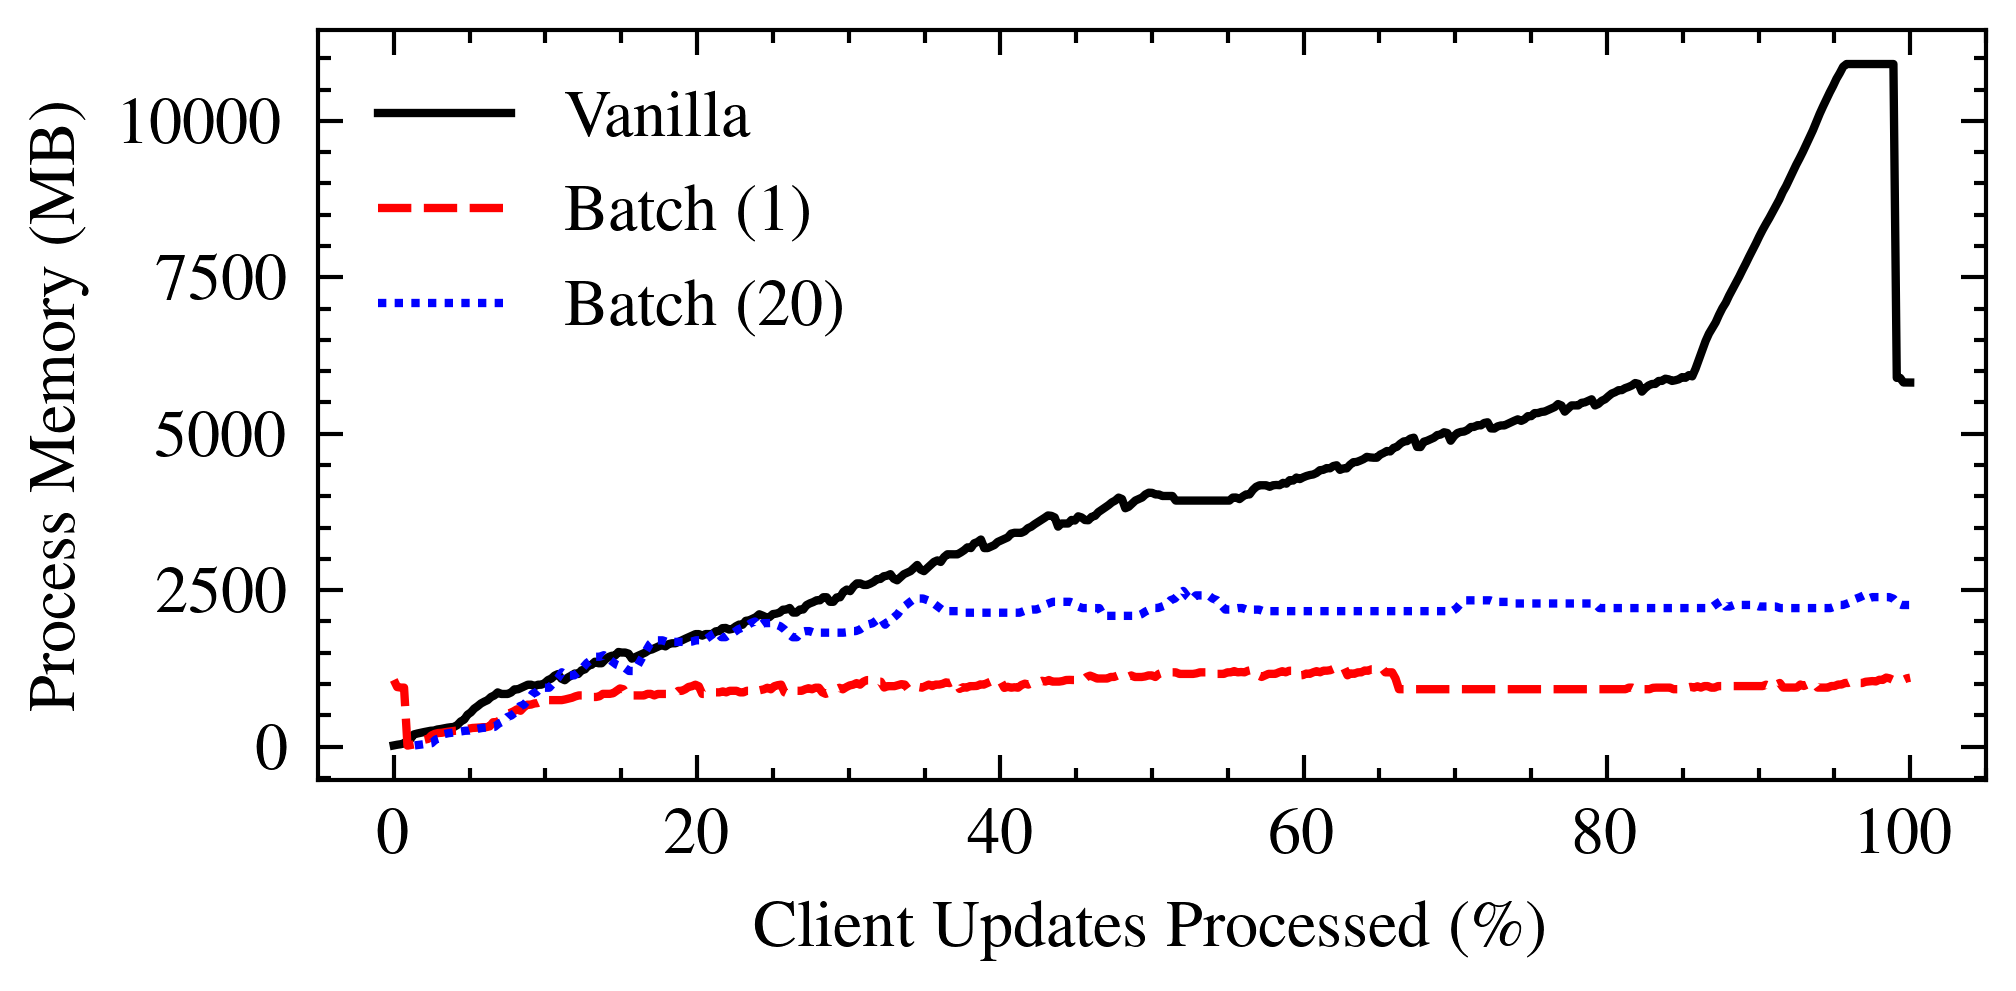

In [47]:
import datetime
aggregator_log_dir = ROOT_OUT_DIR / "aggregation"

df = pd.concat([
    pd.read_csv(aggregator_log_dir / "vanilla.dat", skiprows=2, sep=" ", header=None, usecols=[1, 2]).set_index(2),
    pd.read_csv(aggregator_log_dir / "stream-1.dat", skiprows=2, sep=" ", header=None, usecols=[1, 2]).set_index(2),
    pd.read_csv(aggregator_log_dir / "stream-20.dat", skiprows=2, sep=" ", header=None, usecols=[1, 2]).set_index(2),
], keys=["Vanilla", "Batch (1)", "Batch (20)"], names=["version"]).reset_index()
df.columns = ["version", "time", "memory"]
df["time"] = df["time"].apply(datetime.datetime.utcfromtimestamp)
df = df[df["memory"] > 0.0]

df["timedelta"] = df.reset_index().groupby("version")["time"].transform(lambda x: (x - x.min()))
df["seconds"] = df["timedelta"].apply(lambda x: x.total_seconds())
df["seconds"] = df.groupby("version")["seconds"].transform(lambda x: x / x.max()) * 100

plt.clf()
fig, ax = plt.subplots(figsize=(3.5, 7.167 / 4))
with plt.style.context(['science', 'bright', 'ieee']):
    sns.lineplot(x="seconds", y="memory", data=df, hue="version", style="version", ax=ax, linestyle='-')
#ax.set_xlabel("Seconds")
ax.set_xlabel("Client Updates Processed (\%)")
ax.set_ylabel("Process Memory (MB)")
ax.get_legend().set_title("")
fig.tight_layout()
fig.savefig(PLOT_OUTPUT_DIR / f"running-average-aggregator.pdf" ,bbox_inches = 'tight',pad_inches = 0)

## MNIST with Privacy

<Figure size 1980x1500 with 0 Axes>

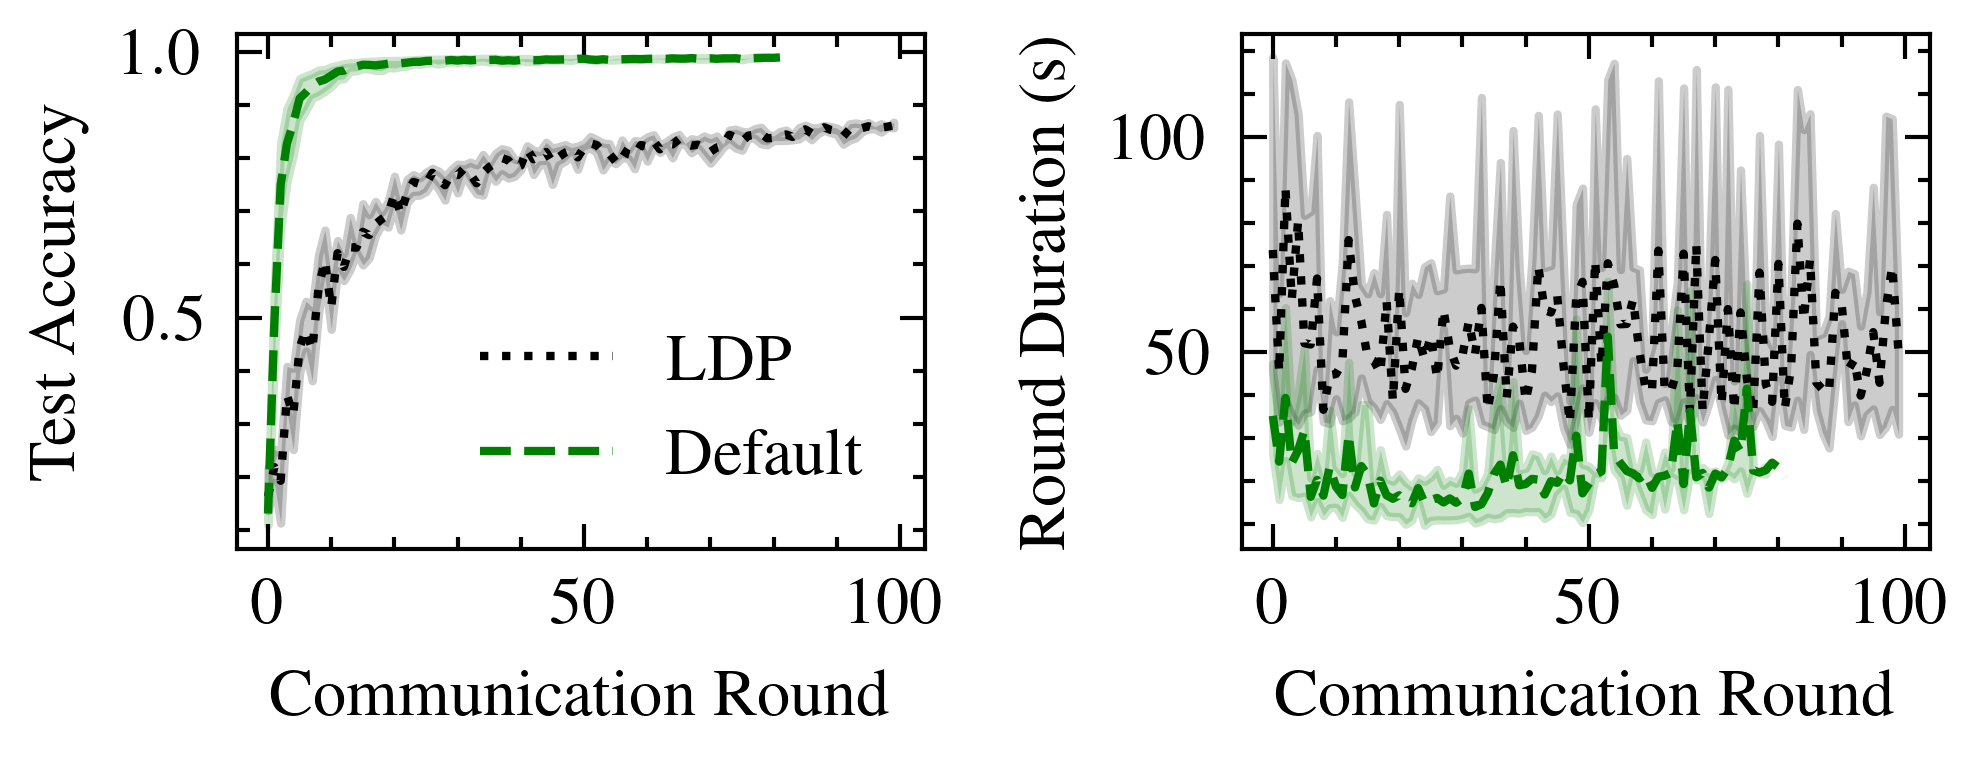

In [165]:
plt.clf()

fig, axarr = plt.subplots(ncols=2, figsize=(3.5, 3.5 / 2.5), sharex=False)

sns.lineplot(x="round", y="accuracy", data=fedless_dp_df.loc[("mnist", 25), :], ax=axarr[0], label="LDP")
sns.lineplot(x="round", y="accuracy", data=fedless_df.loc[("mnist", 25), :], ax=axarr[0], label="Default")

sns.lineplot(x="round", y="time", data=fedless_dp_df.loc[("mnist", 25), :], ax=axarr[1], label="LDP")
sns.lineplot(x="round", y="time", data=fedless_df.loc[("mnist", 25), :], ax=axarr[1], label="Default")

axarr[0].set_xlabel("Communication Round")
axarr[1].set_xlabel("Communication Round")

axarr[0].set_ylabel("Test Accuracy")
axarr[1].set_ylabel("Round Duration (s)")
axarr[1].get_legend().remove()

fig.tight_layout()
fig.savefig(PLOT_OUTPUT_DIR / f"fedless-privacy.pdf", bbox_inches = 'tight', pad_inches = 0)

<Figure size 1980x1500 with 0 Axes>

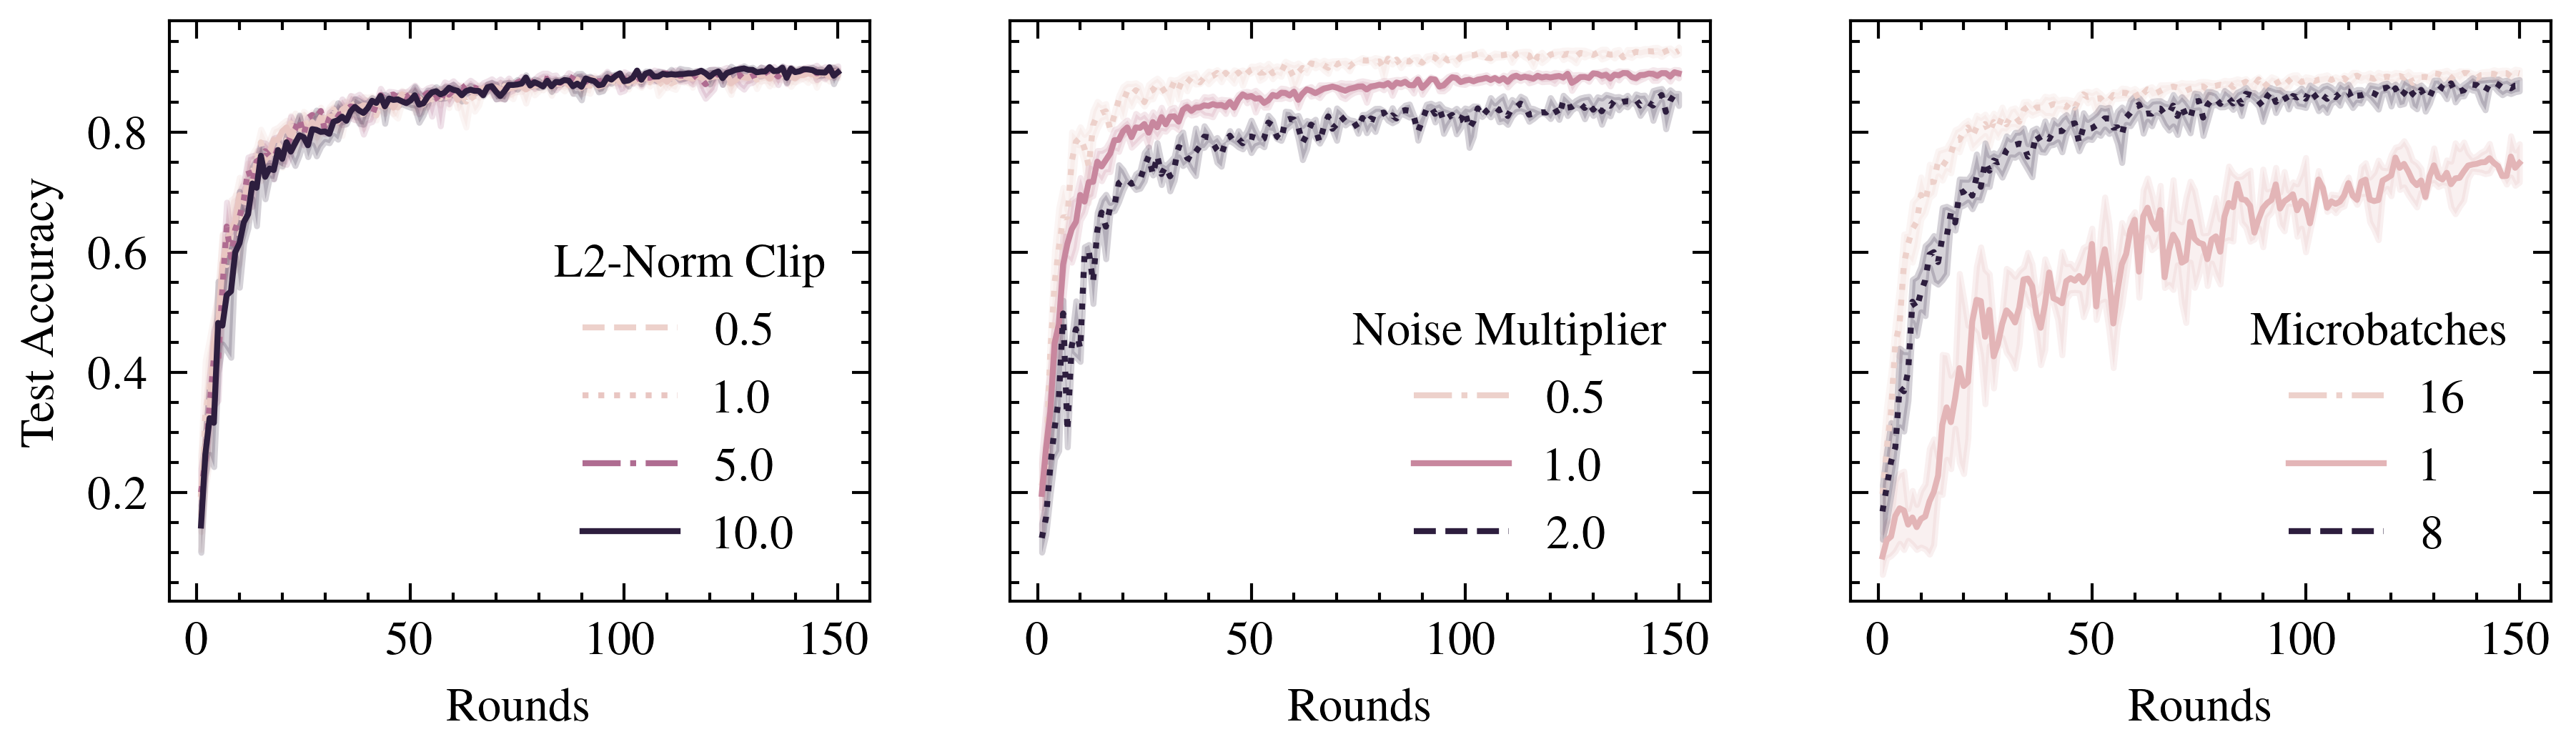

In [18]:
privacy_sim_ldp_df = privacy_sim_df.loc[True]
plt.clf()
fig, axarr = plt.subplots(ncols=3, sharey=True, figsize=(7.167, 7.167 / 4))

sns.lineplot(
    x="epoch",
    y="accuracy",
    hue="l2-norm",
    style="l2-norm",
    data=privacy_sim_ldp_df.loc[(0, slice(0.0, 20.0), 1.0), :],
    ax=axarr[0]
)

sns.lineplot(
    x="epoch",
    y="accuracy",
    hue="noise-multiplier",
    style="noise-multiplier",
    data=privacy_sim_ldp_df.loc[(0, 1.0, slice(0.0, 5.0)), :],
    ax=axarr[1]
)
df_ = privacy_sim_ldp_df.loc[(slice(0, 16)), 1.0, 1.0, :]
sns.lineplot(
    x="epoch",
    y="accuracy",
    hue="microbatches",
    style="microbatches",
    data=privacy_sim_ldp_df.loc[(slice(0, 16)), 1.0, 1.0, :],
    ax=axarr[2]
)

axarr[0].set_xlabel("Communication Round")
axarr[1].set_xlabel("Communication Round")
axarr[2].set_xlabel("Communication Round")


axarr[0].get_legend().set_title("L2-Norm Clip")
axarr[1].get_legend().set_title("Noise Multiplier")
axarr[2].get_legend().set_title("Microbatches")
axarr[2].get_legend().get_texts()[0].set_text('16') # 0 microbatches -> 16

axarr[0].set_ylabel("Test Accuracy")
fig.savefig(PLOT_OUTPUT_DIR / f"fedless-privacy-sim-hyperparameters.pdf", bbox_inches = 'tight', pad_inches = 0)

<Figure size 1980x1500 with 0 Axes>

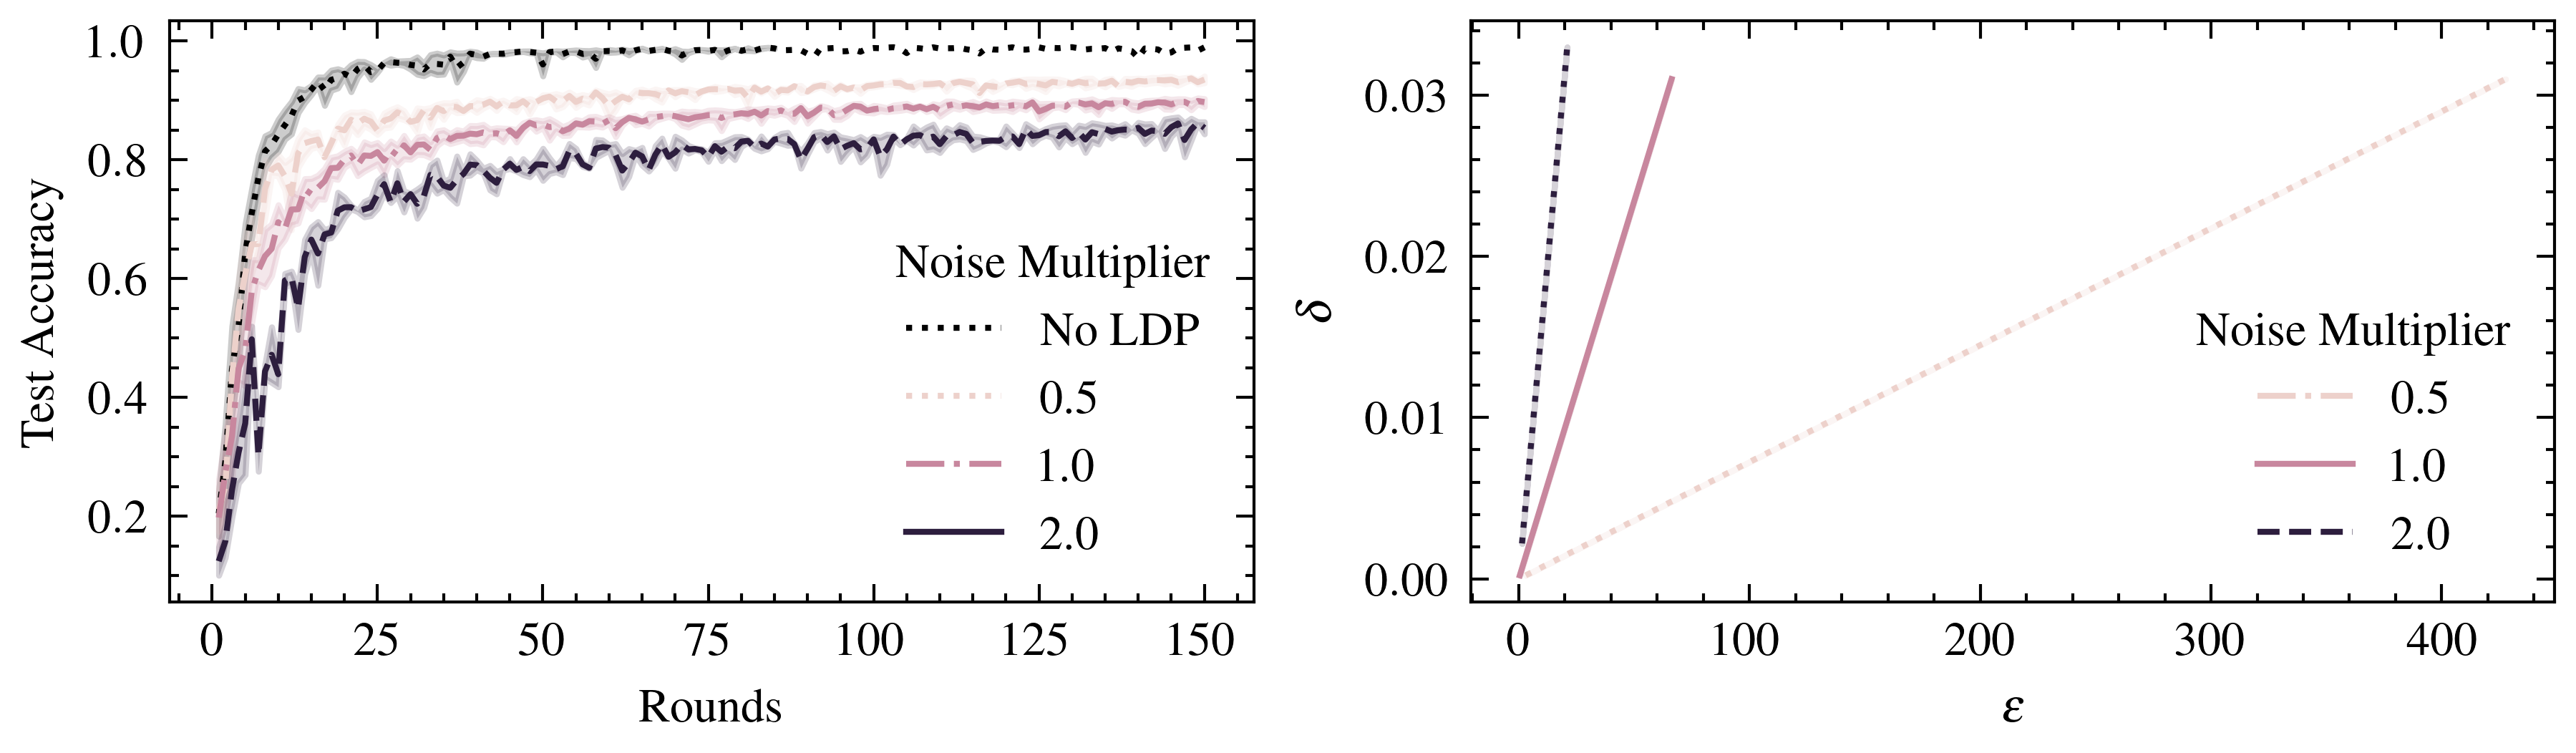

In [19]:
plt.clf()
fig, axarr = plt.subplots(ncols=2, sharex=False, figsize=(7.167, 7.167 / 4))
sns.lineplot(
    x="epoch",
    y="accuracy",
    #hue="l2-norm",
    data=privacy_sim_df.loc[False], # privacy_sim_ldp_df.loc[(0, slice(0.0, 20.0), 1.0), :],
    ax=axarr[0],
    linestyle="-.",
    label="No LDP"
)
sns.lineplot(
    x="epoch",
    y="accuracy",
    hue="noise-multiplier",
    style="noise-multiplier",
    data=privacy_sim_df.loc[(True, 0, 1.0, slice(0.0, 2.0)), :],
    ax=axarr[0],
)
sns.lineplot(
    y="delta-round-clients-cumsum-div",
    x="cum-eps-naive-div",
    hue="noise-multiplier",
    style="noise-multiplier",
    data=privacy_sim_df.loc[(True, 0, 1.0, slice(0.0, 2.0)), :].iloc[::10, :],
    ax=axarr[1],
    #c="blue",
    #label="RDP Accounting"
)

axarr[0].set_xlabel("Communication Round")
axarr[0].set_ylabel("Test Accuracy")
axarr[1].set_xlabel(r"$\varepsilon$")
axarr[1].set_ylabel(r"$\delta$")

axarr[0].get_legend().set_title("Noise Multiplier")
axarr[1].get_legend().set_title("Noise Multiplier")

#fig.savefig(PLOT_OUTPUT_DIR / f"fedless-privacy-noise-accuracy-guarantees.pdf", bbox_inches = 'tight', pad_inches = 0)
fig.savefig(PLOT_OUTPUT_DIR / f"fedless-privacy-noise-accuracy-guarantees.png", dpi=300, bbox_inches = 'tight', pad_inches = 0)

In [20]:
accuracy_df_ = (
    privacy_sim_df.loc[((True, False), slice(0, 16), 1.0, 1.0), :]
    .groupby(["ldp", "microbatches", "time-start"])
    ["accuracy"].max()
    .groupby(["ldp", "microbatches"])
    .mean()
)

time_df_ = (
    privacy_sim_df.loc[((True, False), slice(0, 16), 1.0, 1.0), :]
    .groupby(["ldp", "microbatches"])
    .mean()["time-clients"]
)

df_ = pd.concat([accuracy_df_, time_df_], keys=["accuracy", "time"], names=["metric"]).to_frame()
#df_.reset_index().set_index(["ldp", "microbatches"])
df_ = df_.reset_index()
df_["microbatches"] = df_["microbatches"].apply(lambda x: 16 if x == 0 else x)
print(df_.pivot(index=["ldp", "microbatches"], columns='metric', values=0).T.to_latex())

\begin{tabular}{lrrrr}
\toprule
ldp &      False & \multicolumn{3}{l}{True} \\
microbatches &         16 &         1  &         8  &          16 \\
metric   &            &            &            &             \\
\midrule
accuracy &   0.962489 &   0.768850 &   0.890800 &    0.896533 \\
time     &  19.229603 &  37.056058 &  90.151504 &  182.818033 \\
\bottomrule
\end{tabular}



## FedKeeper vs FedLess

FedLess (35): 4.5466+-1.24303939025048ms, median: 4.212
FedKeeper (Opt.) (66): 3.914878787878788+-0.27050925683771787ms, median: 3.8295
FedKeeper (Orig.) (15): 5.6882666666666655+-2.769687141577948ms, median: 4.46
Optimization Difference: Mean: 1.7653333333333332, Median: 0.6720000000000002, relative: 1.178335535006605


<Figure size 1980x1500 with 0 Axes>

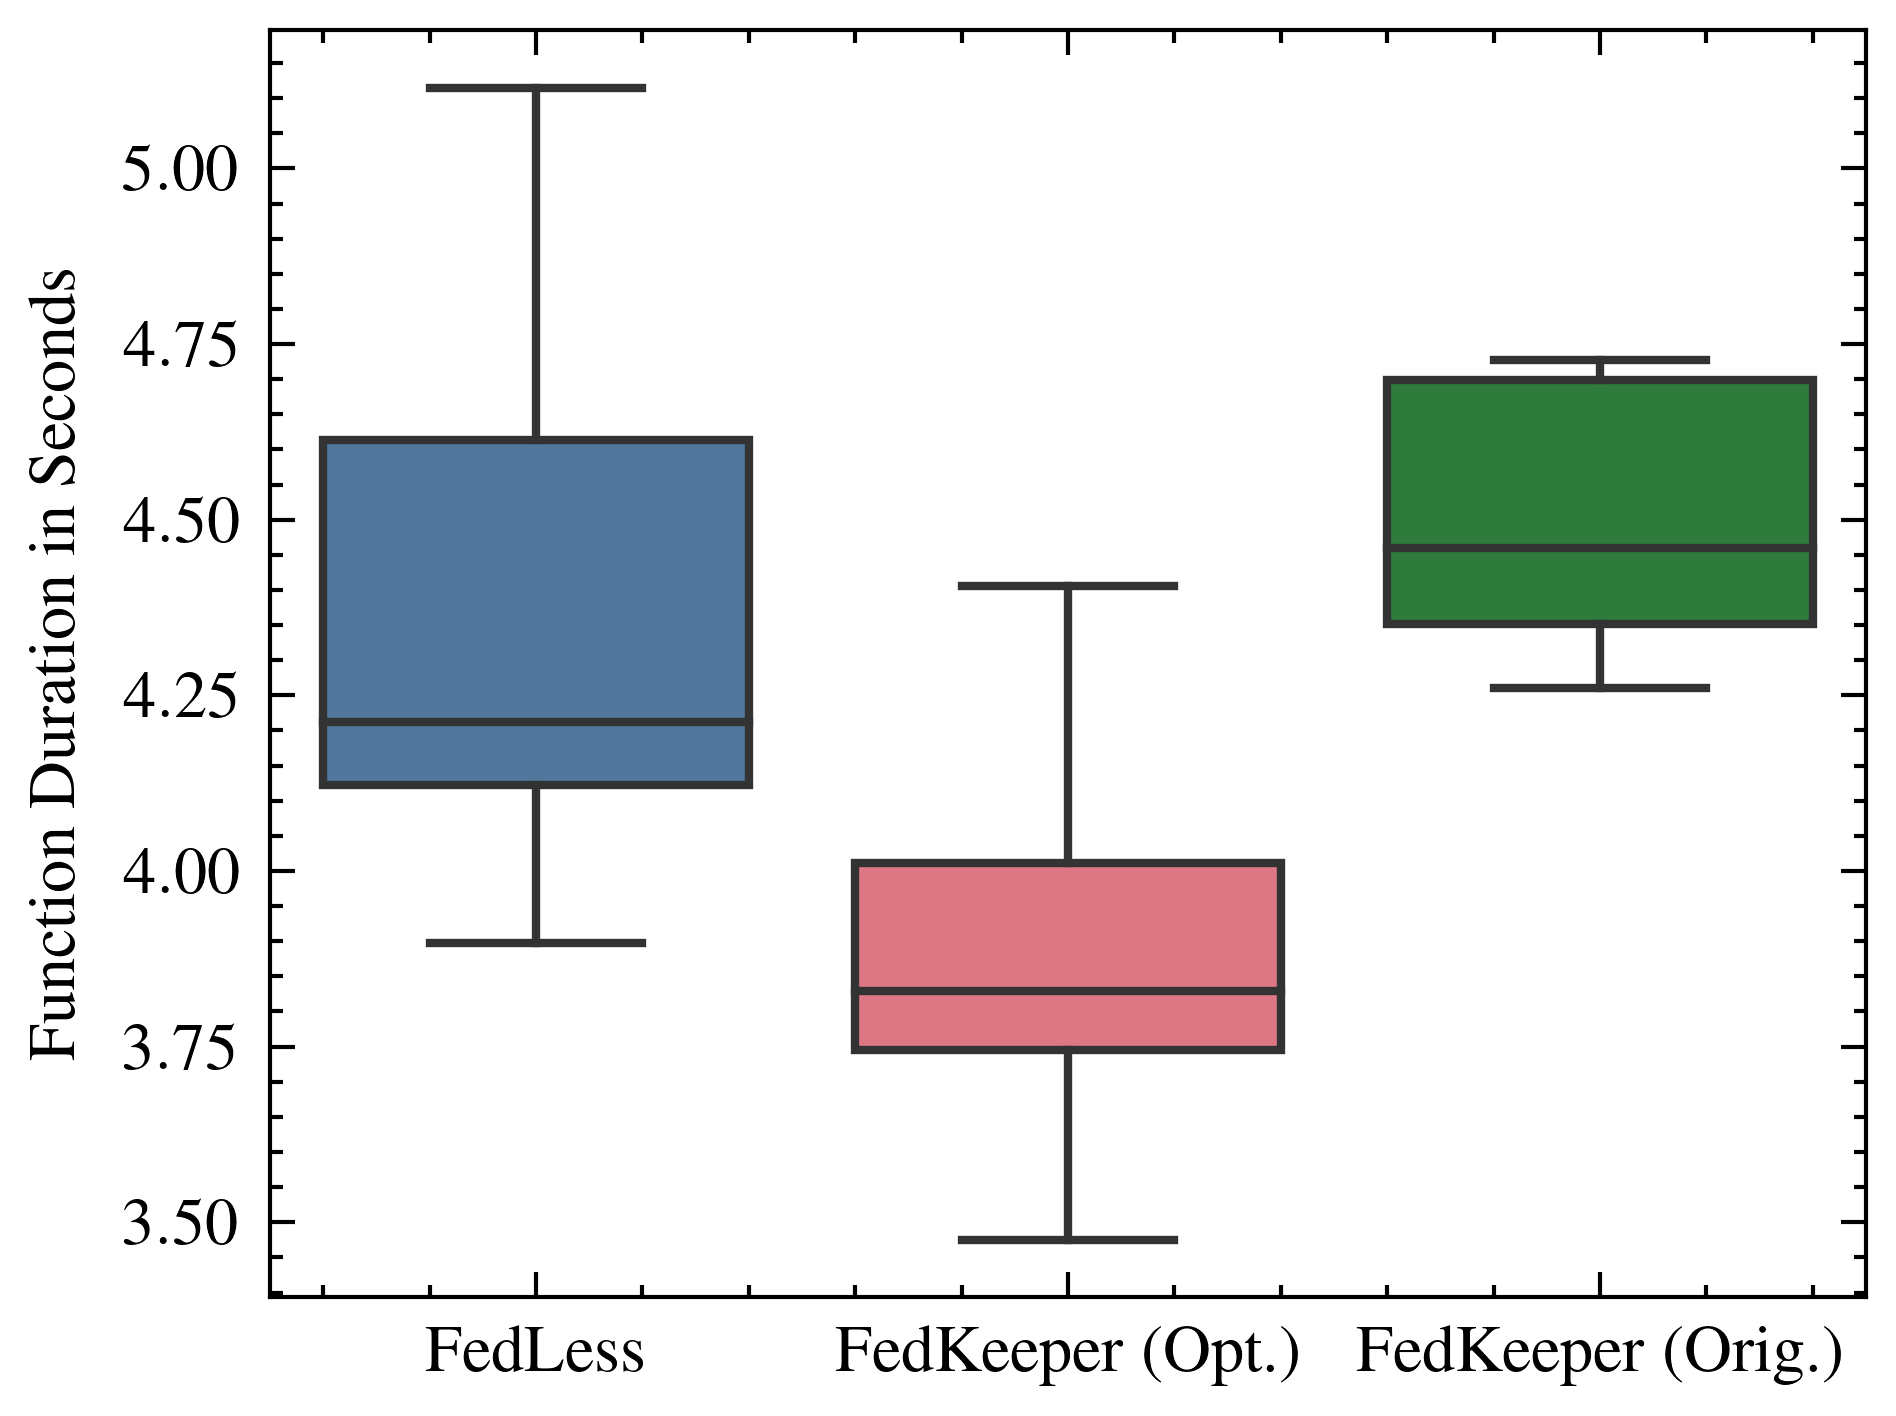

In [44]:
fedkeeper_gcloud_client_1_log_df = pd.read_csv(ROOT_OUT_DIR / "fedkeeper-fedless-gcloud-logs/downloaded-logs-20210805-181515-http-1.csv")
fedless_gcloud_client_1_log_df = pd.read_csv(ROOT_OUT_DIR / "fedkeeper-fedless-gcloud-logs/downloaded-logs-20210805-181149-client-indep-1.csv")
fedkeeper_uncached_gcloud_clientlog_df = pd.read_csv(ROOT_OUT_DIR / "fedkeeper-fedless-gcloud-logs/downloaded-logs-20210806-152324-client-no-caching.csv")


# GCloud Client Functions runtime based on >30 rounds of 1 client each with same hyperparameters
vals = []
for method, df in [("FedLess", fedless_gcloud_client_1_log_df), ("FedKeeper (Opt.)", fedkeeper_gcloud_client_1_log_df), ("FedKeeper (Orig.)", fedkeeper_uncached_gcloud_clientlog_df)]:
    log_statements  = df[df['textPayload'].astype(str).str.contains("Function execution took ")].textPayload
    timings = np.array([float(line[len("Function execution took "):].split(' ')[0]) for line in log_statements]) / 1000
    vals.append((method, timings))
    print(f"{method} ({len(timings)}): {timings.mean()}+-{timings.std()}ms, median: {np.median(timings)}")

df = pd.concat([pd.Series(timings) for _, timings in vals], keys=[m for m, _ in vals], names=["method"]).to_frame().reset_index()
#fedkeeper_optimization_mean_difference = (df[df["method"] == "FedKeeper (Orig.)"][0].median() - df[df["method"] == "FedKeeper (Opt.)"][0].median())   
arr1, arr2 = df[df["method"] == "FedKeeper (Orig.)"][0].values, df[df["method"] == "FedKeeper (Opt.)"][0].values
arr1, arr2 = arr1[:min(len(arr1), len(arr2))], arr2[:min(len(arr1), len(arr2))]
print(f"Optimization Difference: Mean: {(arr1 - arr2).mean()}, Median: {np.median(arr1 - arr2)}, relative: {np.median(arr1 / arr2)}")


#print(f"Mean Difference of Optimized vs Unoptimized FedKeeper: {fedkeeper_optimization_mean_difference}")

plt.clf()
fig, ax = plt.subplots()
with plt.style.context(['science', 'ieee', 'bright']):
    sns.boxplot(x="method", y=0, data=df, ax=ax, showmeans=False, showfliers=False) # showfliers=False => WARM STARTS 
ax.set_xlabel("")
ax.set_ylabel("Function Duration in Seconds")
fig.tight_layout()

## iterate over boxes
#for i,box in enumerate(ax.artists):
#    box.set_edgecolor('black')
#    box.set_facecolor('white')
#
#    # iterate over whiskers and median lines
#    for j in range(5*i,5*(i+1)):
#         ax.lines[j].set_color('black')

fig.savefig(PLOT_OUTPUT_DIR / f"fedless-fedkeeper-clients-duration-warm.pdf", bbox_inches = 'tight', pad_inches = 0)

In [11]:
df[df["method"] == "FedLess"].median()

level_1    17.000
0           4.212
dtype: float64

In [12]:
fedkeeper_unoptimized = fedkeeper_df.loc[("mnist", slice(1, 75), 100),:].reset_index().copy()
#fedkeeper_unoptimized["time"] += fedkeeper_optimization_mean_difference
#   fedkeeper_unoptimized,
fl_fk_comp_df = pd.concat([
    fedkeeper_df.loc[("mnist", slice(1, 75), 100),:].reset_index(),
 
    fedless_df.loc[("mnist", slice(1, 75), 100),:].reset_index()
], keys=["FedKeeper (Optim.)", "FedLess"], names=["method"]).reset_index().set_index(["method", "clients-round"])
fl_fk_comp_df['cumsum'] = fl_fk_comp_df.groupby(["method", "clients-round", "seed"])['time'].transform(pd.Series.cumsum)
fl_fk_comp_df = fl_fk_comp_df.groupby(["method", "clients-round", "round"]).mean()

<Figure size 1980x1500 with 0 Axes>

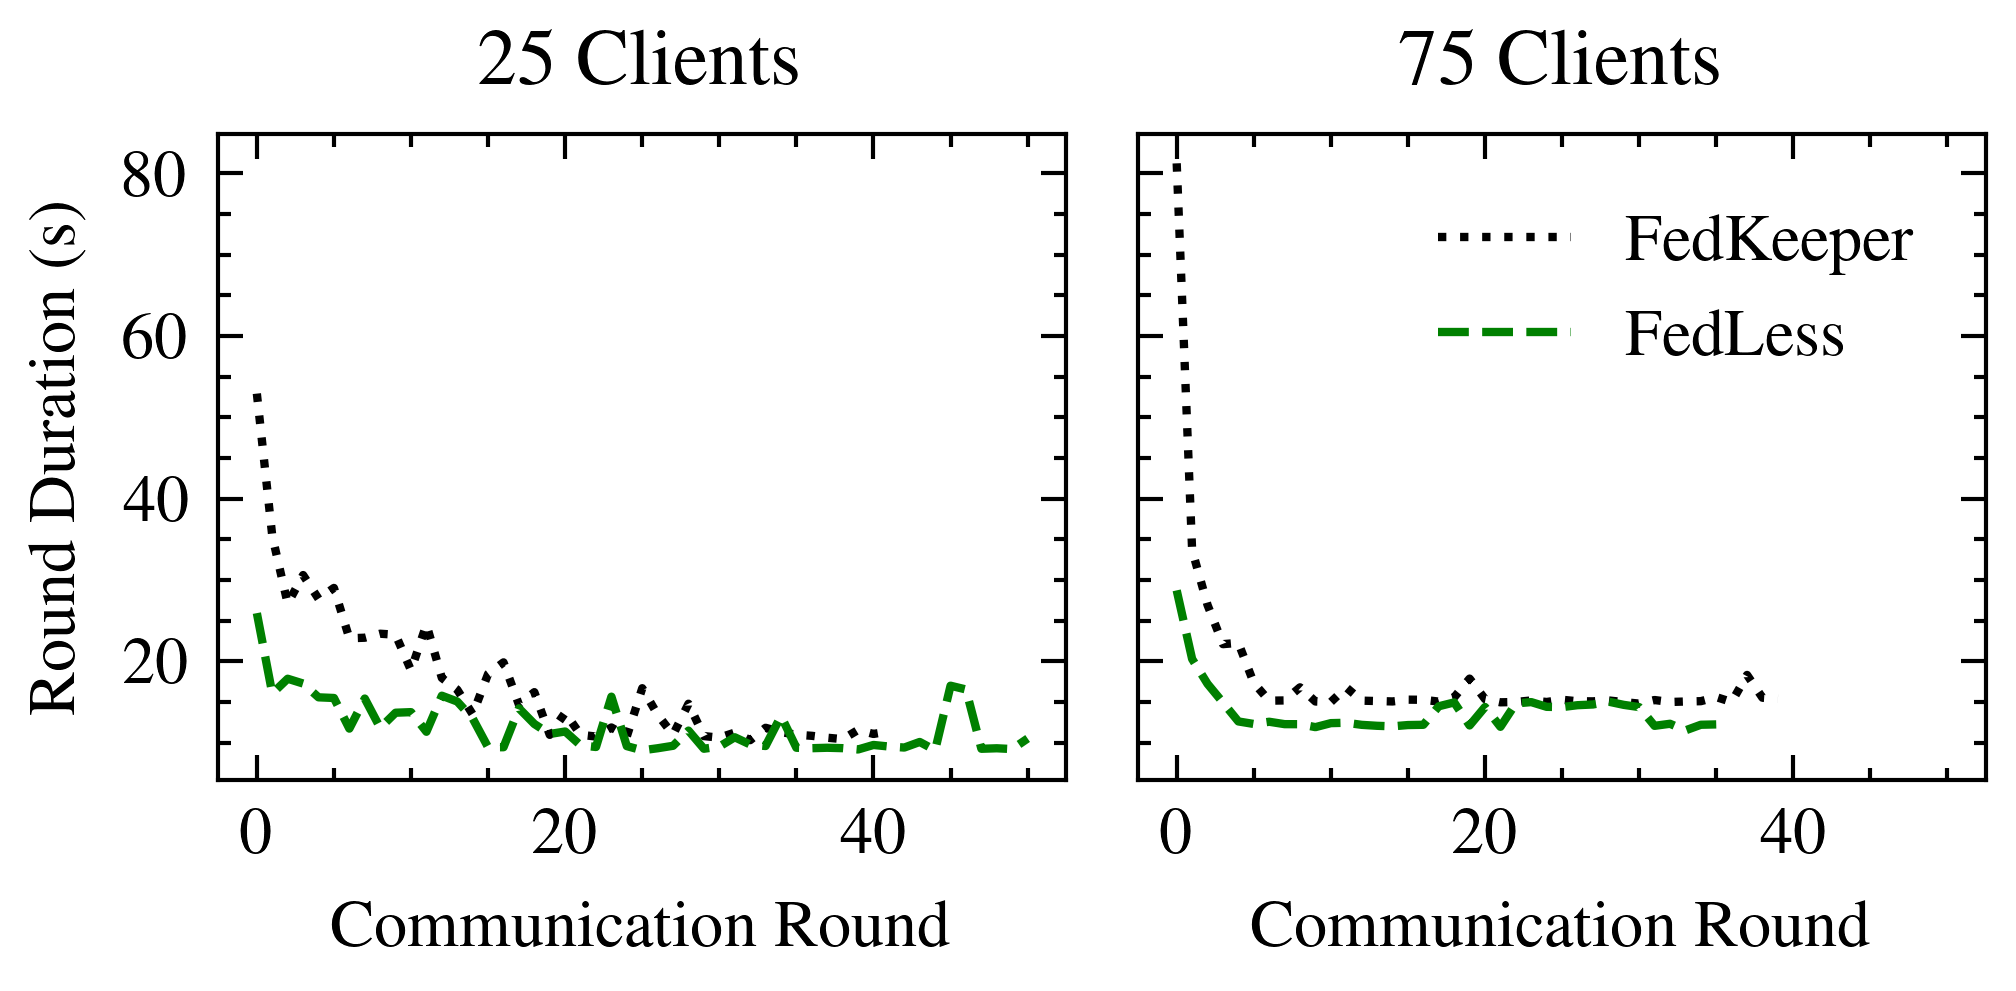

In [28]:
plt.clf()
fig, axarr = plt.subplots(ncols=2, sharey=True, sharex=True, figsize=(3.5, 7.167 / 4))
for i, clients in enumerate([25, 75]): # 50
    sns.lineplot(
        x="round",
        y="time",
        data=fl_fk_comp_df.loc[("FedKeeper (Optim.)", clients), :],
        ax=axarr[i],
        label="FedKeeper"
    )
    #sns.lineplot(
    #    x="round",
    #    y="time",
    #    data=fl_fk_comp_df.loc[("FedKeeper (Orig.)", clients), :],
    #    ax=axarr[i],
    #    label="FedKeeper - Original (Proj.)"
    #)
    sns.lineplot(
        x="round",
        y="time",
        data=fl_fk_comp_df.loc[("FedLess", clients), :],
        ax=axarr[i],
        label="FedLess"
    )
    axarr[i].set_title(f"{clients} Clients")
    axarr[i].set_xlabel("Communication Round")
    axarr[i].set_ylabel("Round Duration (s)")
    axarr[i].get_legend().remove()
    
handles, labels = axarr[-1].get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc=(0.7, 0.6))
fig.tight_layout()
fig.savefig(PLOT_OUTPUT_DIR / f"fedless-fedkeeper-round-durations.pdf", bbox_inches = 'tight', pad_inches = 0)

In [25]:
def mean_std(vals):
    return f"{np.mean(vals).round(1)}$\pm${np.std(vals).round(1)}"
df_ = fl_fk_comp_df.groupby(["method", "clients-round"]).agg({'time': [mean_std]})#[np.mean, np.median, np.std]}).T.round(1)
df_.columns = ["time"]
#print(df_.to_latex())
print(df_.reset_index().pivot(index="clients-round", columns="method").to_latex())

\begin{tabular}{lll}
\toprule
{} & \multicolumn{2}{l}{time} \\
method & FedKeeper (Optim.) &       FedLess \\
clients-round &                    &               \\
\midrule
25            &       17.2\$\textbackslash pm\$8.6 &  11.9\$\textbackslash pm\$3.4 \\
50            &      16.8\$\textbackslash pm\$10.1 &  12.6\$\textbackslash pm\$3.5 \\
75            &      18.2\$\textbackslash pm\$10.7 &  13.9\$\textbackslash pm\$3.1 \\
\bottomrule
\end{tabular}



## Flower vs FedLess

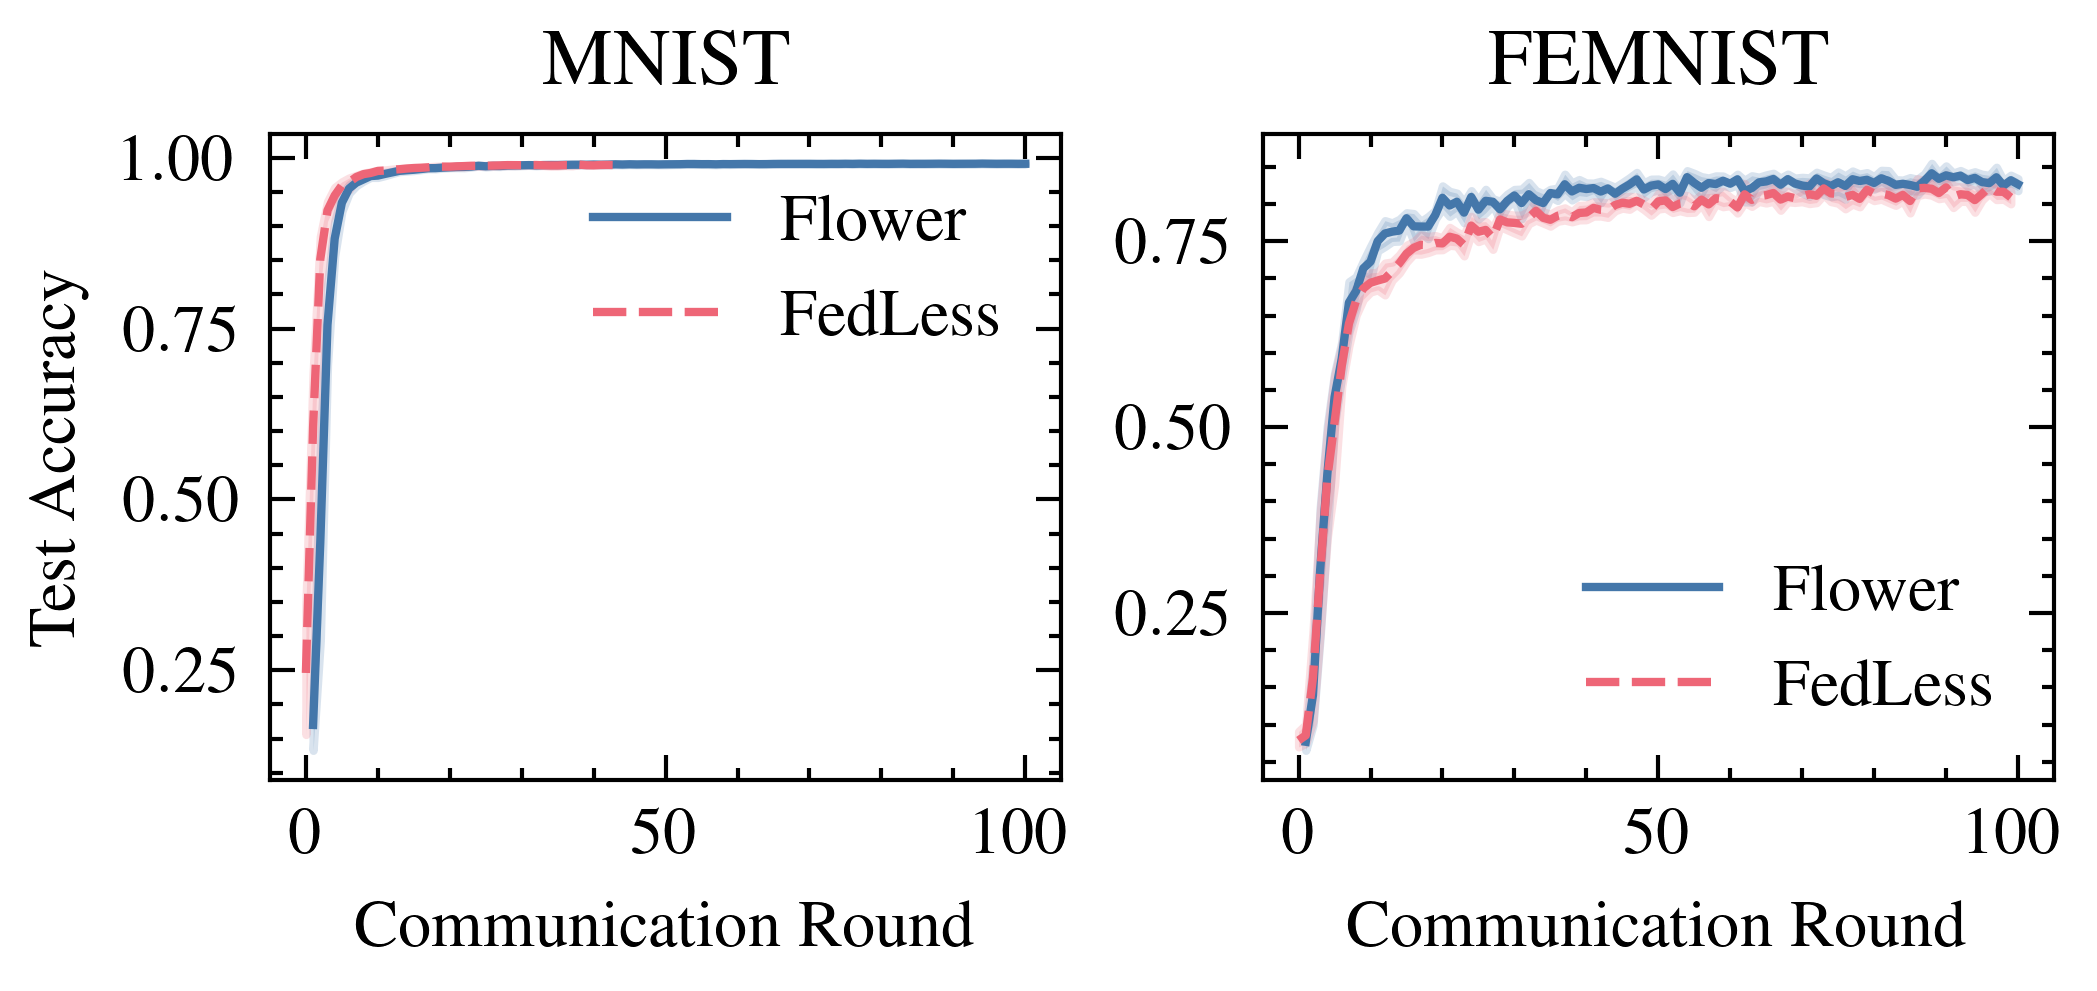

In [171]:
flower_fedless_df = pd.concat([
        flower_df.loc[(("mnist", "femnist"), slice(1, 100), 100, 5, 10), :].reset_index(),
        fedless_flower_df.loc[(("mnist", "femnist"), slice(1, 100), 100, 5, 10, 1), :].reset_index()
    ],
    keys=["Flower", "FedLess"],
    names=["method"]
)
flower_fedless_df = flower_fedless_df[flower_fedless_df["clients-round"] >= 25]
flower_fedless_df["time-total"] = flower_fedless_df.groupby(["method", "dataset", "clients-round", "seed"])["time"].transform(pd.Series.cumsum)
flower_fedless_df = flower_fedless_df.reset_index().set_index(["method", "dataset"])
#flower_fedless_df.loc["Flower"["time-clients-est"] = flower_fedless_df["time"] - flower_fedless_df["time-aggregation"] - (flower_fedless_df["time-eval"])

fig, axarr = plt.subplots(ncols=2, figsize=(7.167 / 2, 7.167 / 4))

df_ = flower_fedless_df.reset_index().set_index(["dataset"])
with plt.style.context(['science', 'ieee', 'bright']):
    sns.lineplot(
        x="round",
        y="accuracy",
        hue="method",
        style="method",
        data=df_.loc["mnist"],
        ci=95,
        ax=axarr[0],
    )
    sns.lineplot(
        x="round",
        y="accuracy",
        hue="method",
        style="method",
        data=df_.loc["femnist"],
        ci=95,
        ax=axarr[1],
    )
    
    axarr[0].set_title("MNIST")
    axarr[1].set_title("FEMNIST")
    
    axarr[0].set_ylabel("Test Accuracy")
    axarr[1].set_ylabel("")
    
    axarr[0].set_xlabel("Communication Round")
    axarr[1].set_xlabel("Communication Round")
    
    axarr[0].get_legend().set_title("")
    axarr[1].get_legend().set_title("")
    

fig.tight_layout()
fig.savefig(PLOT_OUTPUT_DIR / f"fedless-flower-convergence.pdf", bbox_inches = 'tight', pad_inches = 0)

### Timing Comparison

In [172]:
tmp = flower_fedless_df.reset_index().set_index(["method", "dataset", "clients-round"]).copy()
#tmp["time-clients"] = tmp["time"] - tmp["time-aggregation"]
tmp.loc[("Flower", "mnist"), :]["time-clients"] = tmp.loc[("Flower", "mnist"), :]["time"] - tmp.loc[("Flower", "mnist"), :]["time-aggregation"]
df_grouped_ = tmp.groupby(["method", "dataset", "clients-round"]).mean()
fl_flower_timing_df_ = df_grouped_[["time", "time-clients", "time-aggregation"]]
fl_flower_timing_df_

/Users/andreas/workspace/thesis-code/.venv/lib/python3.8/site-packages/pandas/core/indexing.py:889: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
<ipython-input-172-56a454003fbb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp.loc[("Flower", "mnist"), :]["time-clients"] = tmp.loc[("Flower", "mnist"), :]["time"] - tmp.loc[("Flower", "mnist"), :]["time-aggregation"]


time  time-clients  time-aggregation
method  dataset clients-round                                           
FedLess femnist 25             29.892607     21.570089          6.200204
                50             40.260918     26.119035         10.323442
                75             46.991686     27.071869         14.362812
        mnist   25             18.451996     11.182536          7.269125
                50             18.897000     10.931529          7.965160
                75             19.894721     11.505034          8.389370
Flower  femnist 25             16.864100     13.786411          3.077689
                50             22.583373     16.902843          5.680530
                75             27.518120     19.577237          7.940883
        mnist   25             11.433974      6.044267          5.389707
                50             11.632962      6.154605          5.478357
                75             12.086528      6.518947          5.567581

In [173]:
fl_flower_timing_extended_df_  = pd.concat([
    fl_flower_timing_df_.loc["FedLess"],
    fl_flower_timing_df_.loc["Flower"],
    fl_flower_timing_df_.loc["FedLess"] / fl_flower_timing_df_.loc["Flower"],
], keys=["FedLess", "Flower", "Factor"], names=["method"])

In [263]:
df_ = fl_flower_timing_extended_df_#.loc[(("FedLess", "Flower", "Factor"), ("femnist", "mnist"), 75), :]
df_ = df_.reset_index().pivot(index=["dataset", "clients-round"], columns=["method"], values=["time", "time-clients", "time-aggregation"])
df_ = df_.filter([(col, method) for col in ["time", "time-clients", "time-aggregation"] for method in ["FedLess", "Flower", "Factor"]]) # Change column order # , 
df_ = df_.round(1)
timing_cols = [(col, method) for col in ["time", "time-clients", "time-aggregation"] for method in ["FedLess", "Flower"]]
df_[timing_cols] = df_[timing_cols].applymap(lambda x: f"{x}s",)
df_ = df_["time"]

In [264]:
df_ = fl_flower_timing_extended_df_.reset_index().pivot(index=["dataset", "clients-round"], columns=["method"], values=["time", "time-clients", "time-aggregation"])
df_ = df_.filter([(col, method) for col in ["time", "time-clients", "time-aggregation"] for method in ["FedLess", "Flower", "Factor"]]) # Change column order
df_ = df_.round(1)
timing_cols = [(col, method) for col in ["time", "time-clients", "time-aggregation"] for method in ["FedLess", "Flower"]]
#df_[timing_cols] = df_[timing_cols].applymap(lambda x: f"{x}s",)
df_ = df_["time"]
print(df_.to_latex(multirow=True))

\begin{tabular}{llrrr}
\toprule
      & method &  FedLess &  Flower &  Factor \\
dataset & clients-round &          &         &         \\
\midrule
\multirow{3}{*}{femnist} & 25 &     29.9 &    16.9 &     1.8 \\
      & 50 &     40.3 &    22.6 &     1.8 \\
      & 75 &     47.0 &    27.5 &     1.7 \\
\cline{1-5}
\multirow{3}{*}{mnist} & 25 &     18.5 &    11.4 &     1.6 \\
      & 50 &     18.9 &    11.6 &     1.6 \\
      & 75 &     19.9 &    12.1 &     1.6 \\
\bottomrule
\end{tabular}



In [175]:
# To get basis for pricing calculations
flower_median_average_round_time_df = (
    flower_fedless_df.groupby(["dataset", "method", "clients-round", "seed"])["time"]
    .mean()
    .groupby(["dataset", "method", "clients-round"])
    .median()
).to_frame()

df_ = flower_fedless_df.reset_index().set_index(["dataset", "method", "clients-round"])
df_ = df_.loc["mnist"]
df_ = df_[df_["accuracy"] >= 0.99]
df_ = (
    df_.loc["Flower"]
    .groupby(["clients-round", "seed"])[["round", "time-total"]]
    .min()
    .groupby(["clients-round"])
    .median()
)
print("-" * 40)
print("Rounds and Total Times for MNIST")
print(df_)
print("-" * 40)

df_ = flower_fedless_df.reset_index().set_index(["dataset", "method", "clients-round"])
df_ = df_.loc["femnist"]
df_ = df_[df_["accuracy"] >= 0.82]
df_ = (
    df_.loc["Flower"]
    .groupby(["clients-round", "seed"])[["round", "time-total"]]
    .min()
    .groupby(["clients-round"])
    .median()
)
print("-" * 40)
print("Rounds and Total Times for FEMNIST")
print(df_)
print("-" * 40)

----------------------------------------
Rounds and Total Times for MNIST
               round  time-total
clients-round                   
25                36  424.865391
50                34  405.445820
75                37  449.445475
----------------------------------------
----------------------------------------
Rounds and Total Times for FEMNIST
               round  time-total
clients-round                   
25                20     373.547
50                22     498.560
75                29     869.166
----------------------------------------


In [176]:
flower_median_average_round_time_df

time
dataset method  clients-round           
femnist FedLess 25             29.994760
                50             39.921394
                75             46.841592
        Flower  25             16.853370
                50             22.816990
                75             27.576730
mnist   FedLess 25             18.441084
                50             18.930048
                75             19.767014
        Flower  25             11.415632
                50             11.641471
                75             12.040013

In [177]:
# Pricing
from plot_utils import GCLOUD_FUNCTION_TIERS, calc_gcloud_function_cost, calc_lambda_function_cost
from fedless.benchmark.fedkeeper import create_mnist_cnn
from fedless.benchmark.leaf import create_femnist_cnn
from fedless.serialization import NpzWeightsSerializer

def calc_glcoud_n2_cost(
    invocations_total: int,
    instances: int,
    instance_runtime: float,
    function_egress_mb: float,
):
    # e2-standard-2 	2 	8GB 	$0.086334  per hour
    # n2-standard-2 	2 	8GB 	$0.097118
    N2_S_2_HOURLY_PRICE = 0.097118
    NETWORKING_UNIT_PRICE = 0.12

    egress_cost = invocations_total * (function_egress_mb / 1024) * NETWORKING_UNIT_PRICE
    instance_cost = instances * (instance_runtime / 3600) * N2_S_2_HOURLY_PRICE
    return instance_cost + egress_cost

mnist_model_size = sys.getsizeof(NpzWeightsSerializer().serialize(create_mnist_cnn().get_weights())) / 10**6
femnist_model_size = sys.getsizeof(NpzWeightsSerializer().serialize(create_femnist_cnn().get_weights())) / 10**6
function_memory, function_cpu_ghz, _ = 2048, 2.4, 2.9e-06

<Figure size 1980x1500 with 0 Axes>

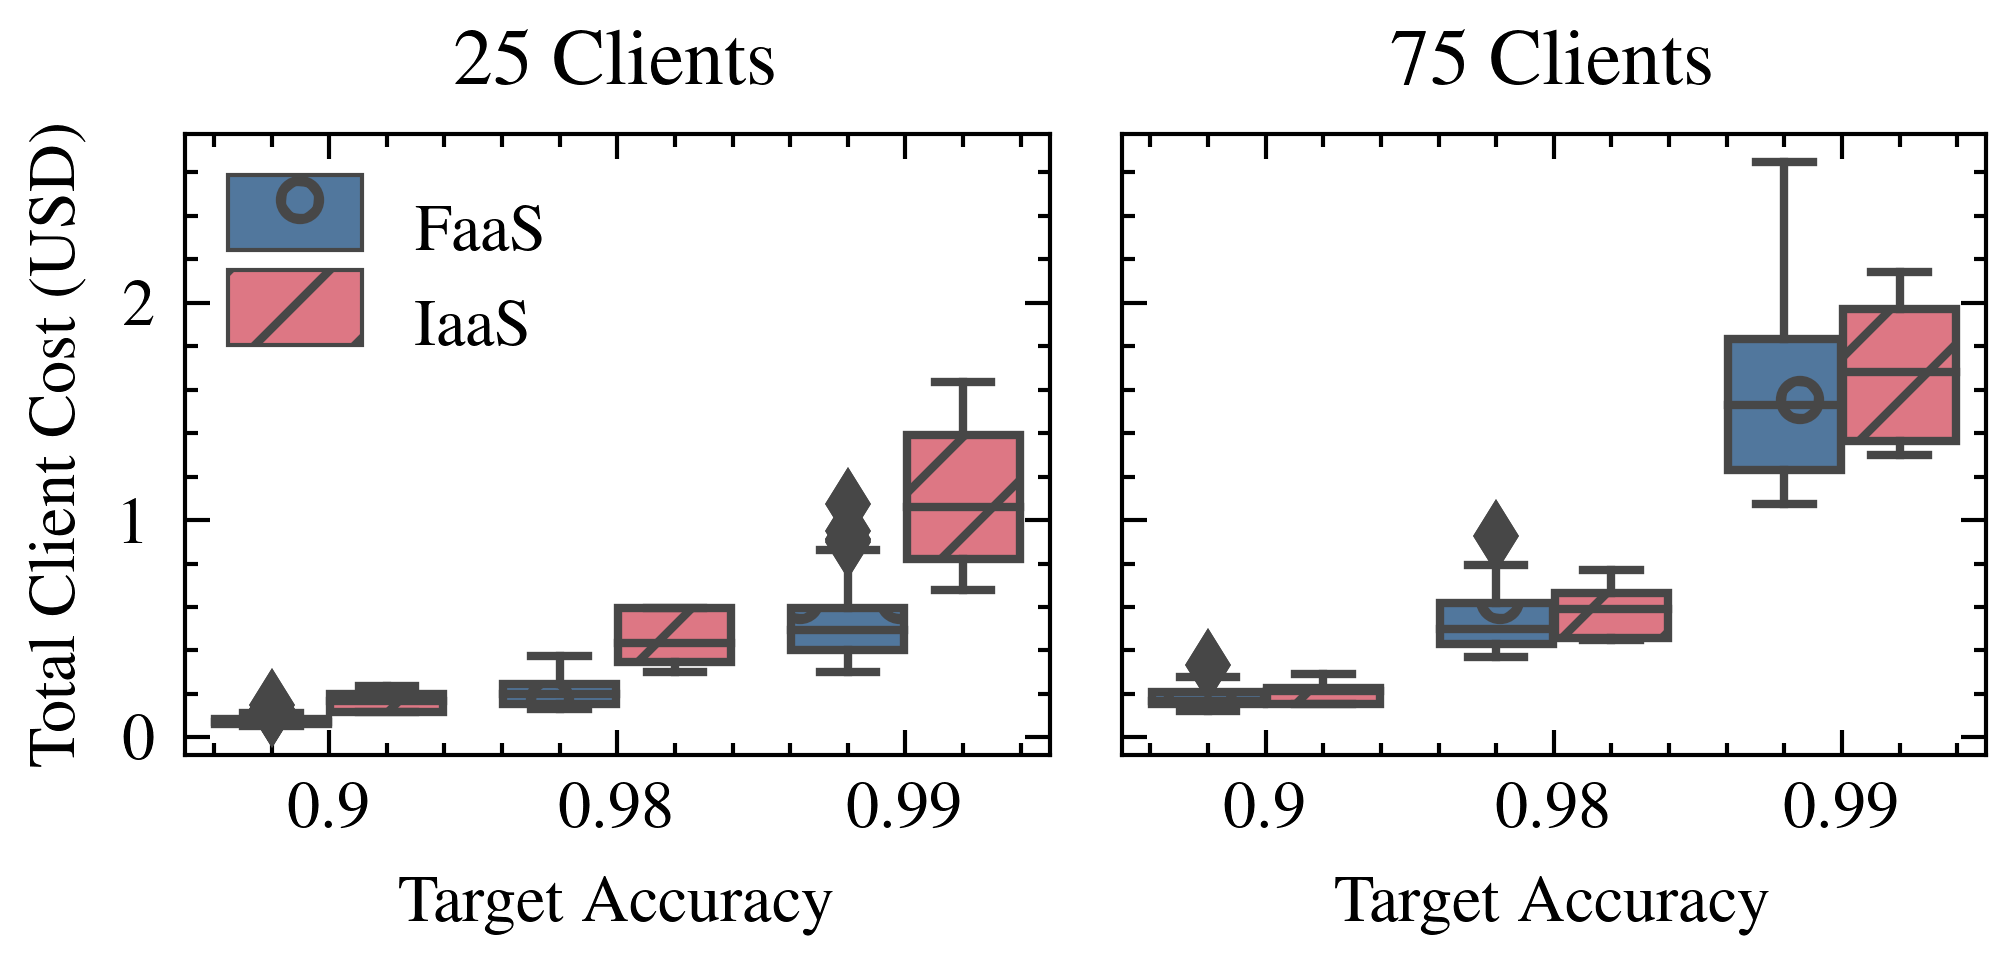

In [186]:
df_ = (
fedless_clients_df
    .loc[("mnist", slice(1, 100), 100), :]
    .groupby(["clients-round", "round"])
    .mean()
    .reset_index()
    .set_index("clients-round")
    [["seconds"]]
)
fedless_timing_dict = {key: val.values[:, 0] for key, val in  df_.groupby("clients-round")}


target_accuracies = [0.9, 0.98, 0.99]

records = []

for clients in [25, 50, 75]:
    for accuracy in target_accuracies:
        df_ = flower_fedless_df.reset_index().set_index(["dataset", "method", "clients-round"]).sort_index()
        df_ = df_.loc[("mnist", "Flower", clients), :]
        df_ = df_[df_["accuracy"] >= accuracy]
        t = list(
            df_
            .groupby(["seed"])[["round", "time-total"]]
            .min()
#            .median()
            .values
        )
        for rounds, fixed_time_total in t:
            #clients_to_gcloud_runtime[clients] *= 
            #
            #time_total = clients_to_gcloud_runtime.get(clients) * rounds
            for fixed_func_runtime in fedless_timing_dict[clients]:
                for func_runtime_multiplier in [1.0, 2.0, 3.0]:
                    for time_total_multiplier in [0.5, 1.0]:
                        time_total = fixed_time_total * time_total_multiplier
                        func_runtime = fixed_func_runtime * func_runtime_multiplier
                        faas_cost = calc_gcloud_function_cost(
                                            memory=function_memory, 
                                            cpu_ghz=function_cpu_ghz,
                                            invocations=rounds * clients,
                                            function_runtime_seconds=func_runtime,
                                            function_egress_mb=mnist_model_size,
                                            substract_free_tier=False)
                        iaas_cost = calc_glcoud_n2_cost(
                            function_egress_mb=mnist_model_size,
                            invocations_total=rounds * clients,
                            instances=100,
                            instance_runtime=time_total
                        )
                        records.append({
                            "clients": clients,
                            "target": accuracy,
                            "type": "FaaS",
                            "cost": faas_cost,
                            "rounds": rounds,
                            "time-total": time_total,
                            "function-runtime": func_runtime,
                        })
                        records.append({
                            "clients": clients,
                            "target": accuracy,
                            "type": "IaaS",
                            "cost": iaas_cost,
                            "rounds": rounds,
                            "time-total": time_total,
                            "function-runtime": func_runtime,
                        })
df_ = pd.DataFrame.from_records(records).set_index("clients")


plt.gcf()
fig, axarr = plt.subplots(ncols=2, figsize=(3.5, 3.5 / 2), sharey=True)

for i, clients in enumerate([25, 75]):
    with plt.style.context(['science', 'ieee', 'bright']):
        sns.boxplot(
            x="target", 
            y="cost", 
            hue="type", 
            data=df_.loc[clients],
            ax=axarr[i]
        )
        axarr[i].set_title(f"{clients} Clients")
        axarr[i].get_legend().set_title("")
        axarr[i].set_xlabel("Target Accuracy")
        
        if i == 0:
            axarr[i].set_ylabel("Total Client Cost (USD)")
        else:
            axarr[i].set_ylabel("")            
            
        hatches = itertools.cycle(['o', '//', '+', 'x', '-', '.', 'x', '\\', '', '', 'O', '.'][:2]) # ['.', '//', '+', '-', 'x', '\\', '', 'o', 'O', '.'])
        for j, patch in enumerate(axarr[i].artists + axarr[i].patches):
            hatch = next(hatches)
            patch.set_hatch(hatch)
        axarr[i].get_legend().remove()
        
        if i == 2:
            axarr[i].xaxis.set_tick_params(labelbottom=True)
            axarr[i].yaxis.set_tick_params(labelright=True)
#        axarr[i].yaxis.set_tick_params(which='both', labelbottom=True)
        #plt.setp(axarr[i].artists, edgecolor = 'k', facecolor='w')
        #plt.setp(axarr[i].lines, color='k')
        #plt.setp(axarr[i].patches, color='k')
    
handles, labels = axarr[-1].get_legend_handles_labels()
    
leg = fig.legend(handles, labels, loc=(0.1, 0.6))
for patch in leg.get_patches():
    patch.set_height(9)
fig.tight_layout()
df_.groupby(["clients", "target"]).agg([np.min, np.max])[["time-total", "function-runtime"]]

fig.savefig(PLOT_OUTPUT_DIR / f"pricing-mnist.pdf", bbox_inches = 'tight', pad_inches = 0)

#df_.describe()[["time-total", "function-runtime"]].loc[(("min", "max", "mean", "std")), :]

,target,cost,rounds,time-total,function-runtime
count,14544.000000,14544.000000,14544.000000,14544.000000,14544.000000
mean,0.775000,1.721887,17.250000,234.683500,11.228865
std,0.055904,0.952166,9.157507,141.018048,5.675774
min,0.700000,0.548881,7.000000,72.225500,1.391025
25%,0.737500,1.023505,11.000000,138.562500,5.522683
50%,0.775000,1.515382,14.500000,197.041750,10.510979
75%,0.812500,2.051724,20.000000,303.431750,15.264125
max,0.850000,5.151572,42.000000,704.692000,50.800172


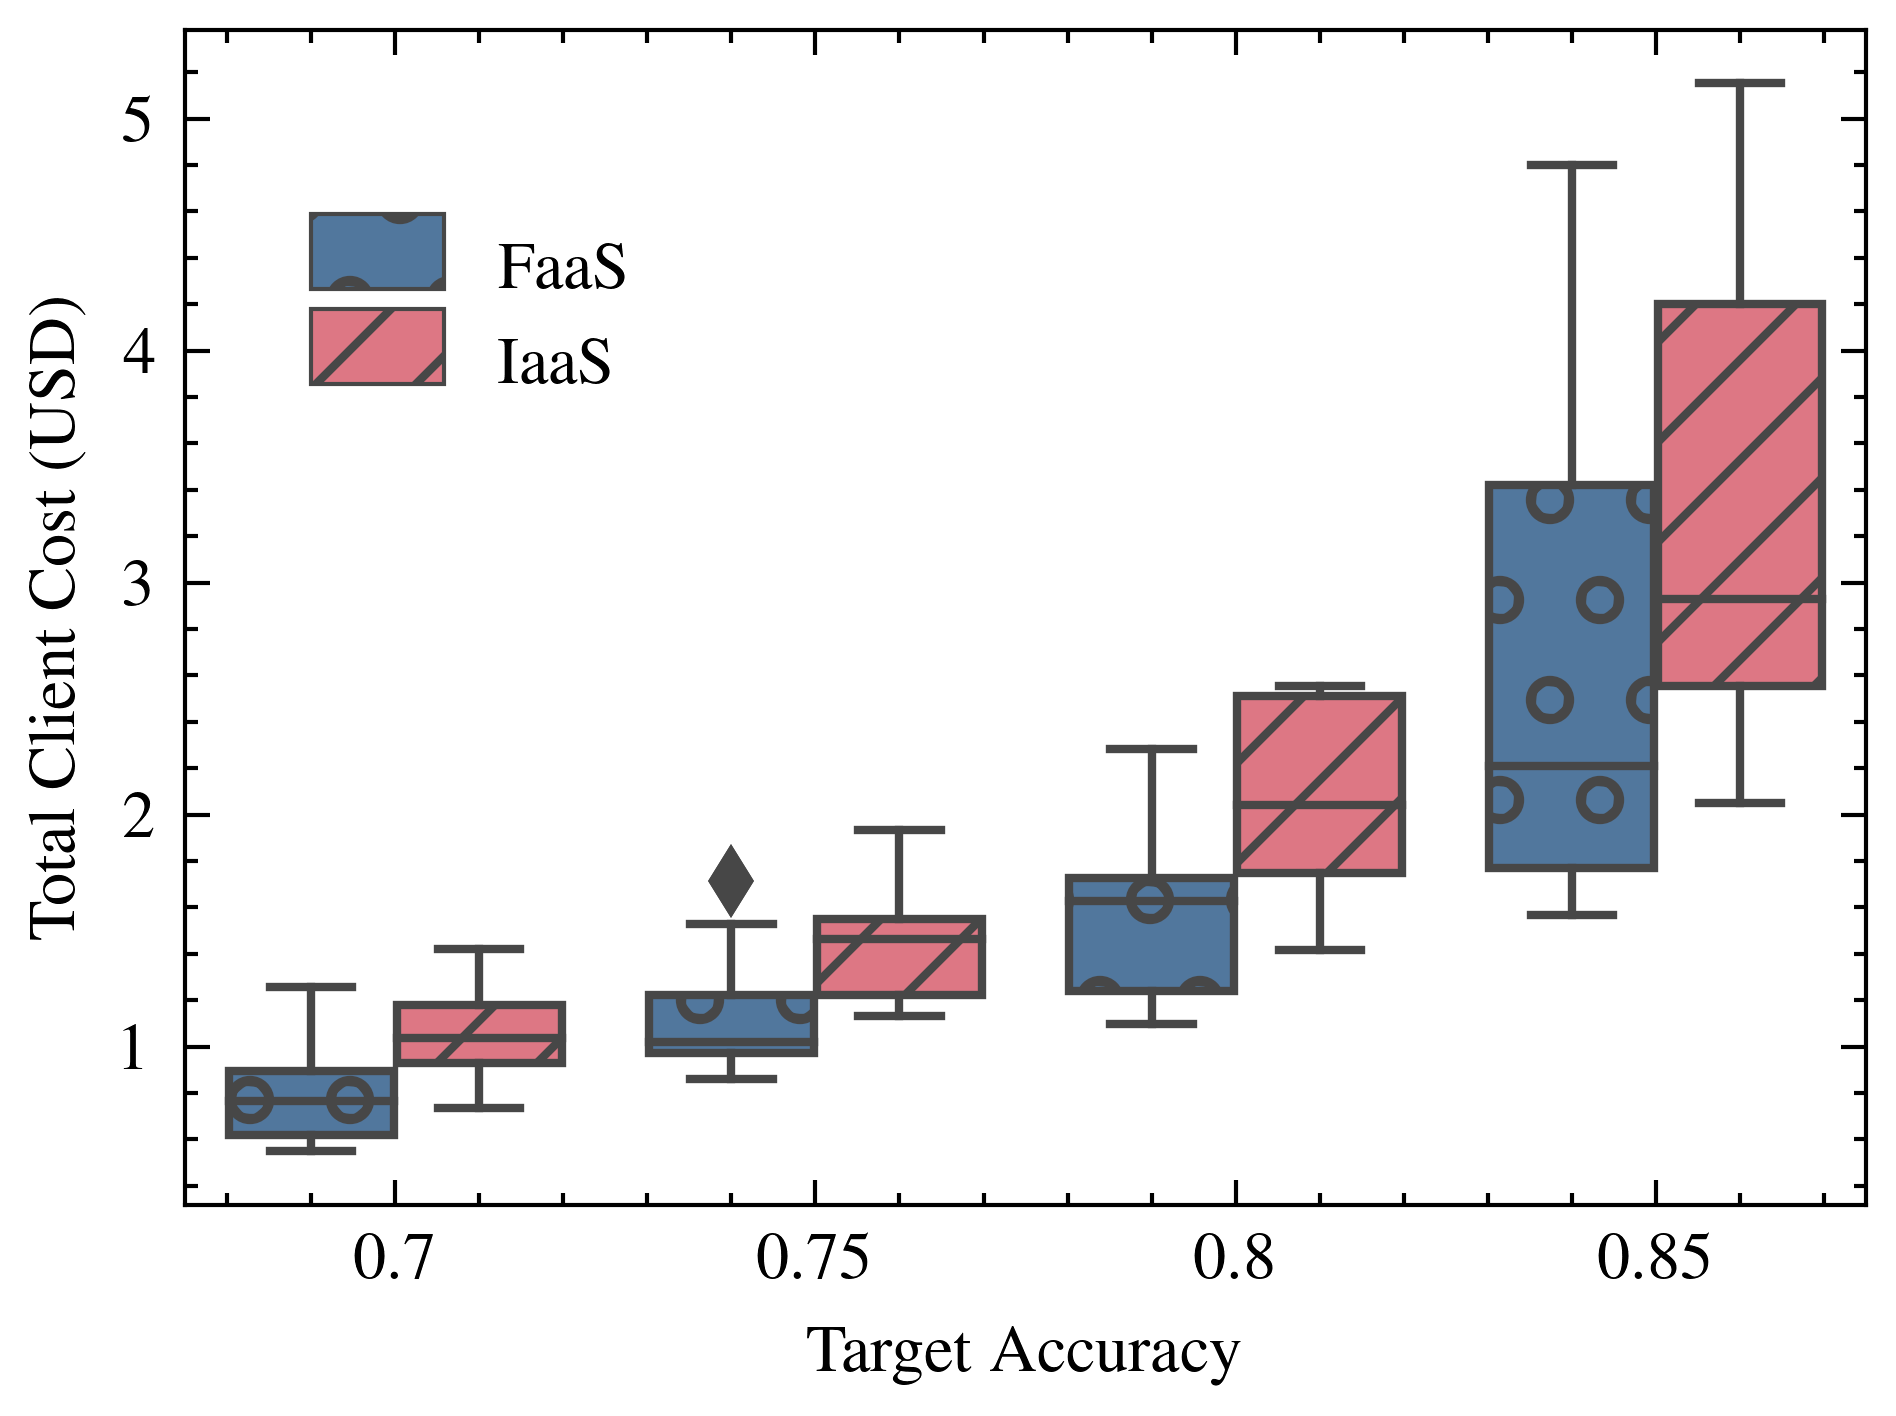

In [187]:
df_ = (
fedless_clients_df
    .loc[("femnist", slice(1, 100), 200), :]
    .groupby(["clients-round", "round"])
    .mean()
    .reset_index()
    .set_index("clients-round")
    [["seconds"]]
)
fedless_timing_dict = {key: val.values[:, 0] for key, val in  df_.groupby("clients-round")}


target_accuracies = [0.7, 0.75, 0.8, 0.85]

records = []

for clients in [25]:
    for accuracy in target_accuracies:
        df_ = flower_fedless_df.reset_index().set_index(["dataset", "method", "clients-round"]).sort_index()
        df_ = df_.loc[("femnist", "Flower", clients), :]
        df_ = df_[df_["accuracy"] >= accuracy]
        t = list(
            df_
            .groupby(["seed"])[["round", "time-total"]]
            .min()
#            .median()
            .values
        )
        for rounds, fixed_time_total in t:
            #clients_to_gcloud_runtime[clients] *= 
            #
            #time_total = clients_to_gcloud_runtime.get(clients) * rounds
            for fixed_func_runtime in fedless_timing_dict[clients]:
                for func_runtime_multiplier in [1.0, 2.0, 3.0]:
                    for time_total_multiplier in [0.5, 1.0]:
                        time_total = fixed_time_total * time_total_multiplier
                        func_runtime = fixed_func_runtime * func_runtime_multiplier
                        faas_cost = calc_gcloud_function_cost(
                                            memory=function_memory, 
                                            cpu_ghz=function_cpu_ghz,
                                            invocations=rounds * clients,
                                            function_runtime_seconds=func_runtime,
                                            function_egress_mb=femnist_model_size,
                                            substract_free_tier=False)
                        iaas_cost = calc_glcoud_n2_cost(
                            function_egress_mb=femnist_model_size,
                            invocations_total=rounds * clients,
                            instances=100,
                            instance_runtime=time_total
                        )
                        records.append({
                            "clients": clients,
                            "target": accuracy,
                            "type": "FaaS",
                            "cost": faas_cost,
                            "rounds": rounds,
                            "time-total": time_total,
                            "function-runtime": func_runtime,
                        })
                        records.append({
                            "clients": clients,
                            "target": accuracy,
                            "type": "IaaS",
                            "cost": iaas_cost,
                            "rounds": rounds,
                            "time-total": time_total,
                            "function-runtime": func_runtime,
                        })
#        print(f"Total Runtime: {np.min()}")

df_ = pd.DataFrame.from_records(records).set_index("clients")

fig, ax = plt.subplots()

plt.gcf()

with plt.style.context(['science', 'ieee', 'bright']):
    sns.boxplot(
        x="target", 
        y="cost", 
        hue="type", 
    #    palette="YlGnBu_d", 
        data=df_.reset_index(),
        ax=ax
    )
ax.set_ylabel("Total Client Cost (USD)")
#ax.set_title(f"{clients} Clients")
ax.get_legend().set_title("")
ax.set_xlabel("Target Accuracy")

hatches = itertools.cycle(['o', '//', '+', 'x', '-', '.', 'x', '\\', '', '', 'O', '.'][:2]) # ['.', '//', '+', '-', 'x', '\\', '', 'o', 'O', '.'])
for j, patch in enumerate(ax.artists + ax.patches):
    hatch = next(hatches)
    patch.set_hatch(hatch)

handles, labels = ax.get_legend_handles_labels()    
ax.get_legend().remove()
leg = fig.legend(handles, labels, loc=(0.15, 0.7))
for patch in leg.get_patches():
    patch.set_height(9)
fig.tight_layout()

fig.savefig(PLOT_OUTPUT_DIR / f"pricing-femnist.pdf", bbox_inches = 'tight', pad_inches = 0)

df_.describe()